In [33]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scp
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from glob import glob

sns.set(context='talk', style='white')

study_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CRAB/CRAB_lab/studies/crab-seal_hbcdmovies_pilot_2025'
data_dir = os.path.join(study_dir, 'DATA','V1_motion_processed')
figs_dir = './figs'
subinfo = pd.read_csv(os.path.join(study_dir,'DATA','redcap_exports','ChildMovieStudy-Basics_DATA_2025-07-15_1335.csv'),index_col=0)
clipinfo = pd.read_csv(os.path.join(study_dir, 'measures','clips','clipinfo.csv'), index_col=0)

subs = sorted(os.listdir(data_dir))
subs.remove('.DS_Store')
subinfo.index = subinfo.index.astype(str)
print('Sample size analyzed so far: {0}'.format(len(subs)))

Sample size analyzed so far: 55


## Motion analysis  and plots
Notes
* meanFD = average FD across the movie
* pcCens9 = pecent censored if the FD threshold is 0.9mm FD
* pcCens2 = pecent censored if the FD threshold is 0.2mm FD
* each dot is color coded by participant ID (some colors are very similar though)

In [13]:
data = pd.DataFrame()
i=0
for sub in subs:
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_summary.csv'.format(sub)), index_col=0)
    for movie in subdata.index:
        if np.isfinite(subdata.loc[movie, 'meanFD']):
            data.loc[i, 'sub'] = sub
            try:
                data.loc[i, 'age'] = subinfo.loc[sub, 'child_age_realtime']
                data.loc[i, 'sex'] = subinfo.loc[sub, 'c_gender']-1
            except:
                print(sub)
                pass
            data.loc[i, 'movie'] = movie
            data.loc[i, 'human'] = clipinfo.loc[movie,'humans']
            data.loc[i, 'speaking'] = clipinfo.loc[movie,'speaking']
            data.loc[i, 'contained'] = clipinfo.loc[movie,'contained']
            data.loc[i, 'meanFD'] = subdata.loc[movie, 'meanFD']
            data.loc[i, 'grandmeanFD'] = subdata.loc[:, 'meanFD'].mean()
            if data.loc[i, 'grandmeanFD'] >= 0.6:
                data.loc[i, 'motiongroup'] = 'high'
            else:
                data.loc[i, 'motiongroup'] = 'low'
            data.loc[i, 'pcCens9'] = subdata.loc[movie, 'pcent_volscens_0.9']*100
            data.loc[i, 'pcCens2'] = subdata.loc[movie, 'pcent_volscens_0.2']*100
            try:
                data.loc[i, 'interest'] = subdata.loc[movie, 'interest']
                data.loc[i, 'pos_aff'] = subdata.loc[movie, 'pos_aff']
                data.loc[i, 'neg_aff'] = subdata.loc[movie, 'neg_aff']
                data.loc[i, 'aff_intensity'] = subdata.loc[movie, 'aff_intensity']
            except:
                pass
            i=i+1

data = data.sort_values('movie')
data.describe()

age         sex       human    speaking   contained      meanFD  \
count  288.000000  288.000000  288.000000  288.000000  288.000000  288.000000   
mean     5.590278    0.534722    0.475694    0.611111    0.760417    1.076186   
std      1.744731    0.499661    0.500278    0.488347    0.427572    1.347301   
min      3.000000    0.000000    0.000000    0.000000    0.000000    0.076811   
25%      4.000000    0.000000    0.000000    0.000000    1.000000    0.278679   
50%      5.000000    1.000000    0.000000    1.000000    1.000000    0.531760   
75%      7.000000    1.000000    1.000000    1.000000    1.000000    1.373432   
max      8.000000    1.000000    1.000000    1.000000    1.000000    8.792722   

       grandmeanFD     pcCens9     pcCens2    interest     pos_aff  \
count   288.000000  288.000000  288.000000  273.000000  272.000000   
mean      1.076186   17.048808   44.555100    1.930403    0.930147   
std       1.012544   16.866574   25.005865    1.302822    1.089488   
min       0.087382    0.000000    2.873563    0.000000    0.000000   
25%       0.352355    4.840120   24.858807    1.000000    0.000000   
50%       0.627475   10.615396   39.709833    2.000000    1.000000   
75%       1.519002   23.362581   64.596053    3.000000    2.000000   
max       7.958658   74.983005   99.516519    4.000000    4.000000   

          neg_aff  aff_intensity  
count  273.000000     273.000000  
mean     0.293040       0.934066  
std      0.703345       1.005158  
min      0.000000       0.000000  
25%      0.000000       0.000000  
50%      0.000000       1.000000  
75%      0.000000       1.000000  
max      4.000000       4.000000

### Identify high and low motion kids

0.6681291059684689


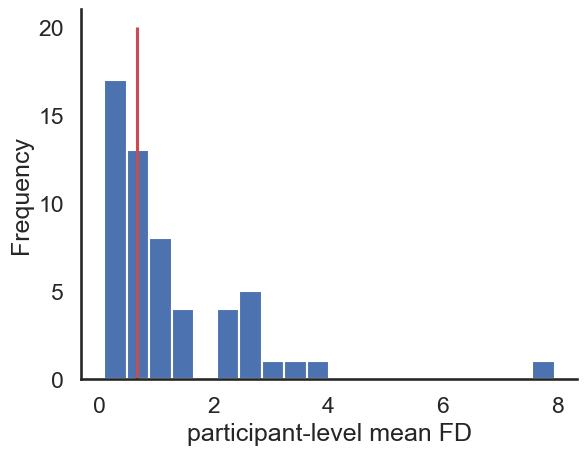

In [14]:
subtempdata = data.loc[:,['sub','age','sex','grandmeanFD']].copy()
subtempdata = subtempdata.drop_duplicates()

subtempdata.loc[:,'grandmeanFD'].plot(kind='hist', bins=20)
plt.vlines(np.nanpercentile(subtempdata.loc[:,'grandmeanFD'].to_numpy(), 50), ymin=0, ymax=20, color='r')
print(np.nanpercentile(subtempdata.loc[:,'grandmeanFD'].to_numpy(), 50))
sns.despine()
plt.xlabel('participant-level mean FD')
plt.show()
plt.close()

### mixed effects models examining movie and other factors predicting motion

#### Full sample

The below cell has results from a mixed effect model predicting FD from movie, age, and sex, modeling each participant as a random intercept. Individual participant and age are the strongest predictors of FD.

The order of movies from LEAST motion to MOST after accounting for these features is listed after the model results below.

In [16]:
res = smf.mixedlm('meanFD ~ age + sex', groups='sub', data=data).fit()
data.loc[:, 'meanFD_res'] = res.resid
print(res.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 288     Method:             REML     
No. Groups:       55      Scale:              1.0171   
Min. group size:  1       Log-Likelihood:     -454.4016
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.984    0.462  6.465 0.000  2.079  3.889
age          -0.315    0.074 -4.251 0.000 -0.460 -0.170
sex          -0.178    0.258 -0.689 0.491 -0.684  0.328
sub Var       0.700    0.226                           



In [37]:
# rank means = resid FD
means = pd.DataFrame()
for m in np.unique(data.loc[:,'movie']):
    means.loc[m, 'FD'] = data.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(data.loc[data['movie']==m1,'meanFD_res'], 
                         data.loc[data['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1     bao        one_man_band -0.086779  0.931669
2     bao  sanjays_super_team -0.383072  0.705516
3     bao     partysaurus_rex -0.414456  0.682743
4     bao       mikes_new_car -0.360320  0.721760
5     bao            zootopia -0.455452  0.652878
6     bao       party_central -0.707618  0.485998
7     bao           small_fry -0.866532  0.396475
8     bao       despicable_me -0.689828  0.497204
9     bao       partly_cloudy -0.739550  0.466746
10    bao               bluey -0.866821  0.394993
11    bao             boundin -0.674104  0.506964
12    bao           air_mater -0.847149  0.405281
13    bao            aeronaut -1.941215  0.065150
14    bao               birds -0.938715  0.358070
15    bao                 lou -0.777416  0.445193
16    bao              frozen -2.642840  0.014862
17    bao               piper -2.190903  0.039879
18    bao          inside_out -1.160439  0.257284
19    bao             la_luna -1.719893  0.100890
20    bao               moana -1.289929  0.211100
21    bao     jackjack_attack -0.940995  0.357935

In [38]:
# rank means = raw FD
means = pd.DataFrame()
for m in np.unique(data.loc[:,'movie']):
    means.loc[m, 'FD'] = data.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(data.loc[data['movie']==m1,'meanFD'], 
                         data.loc[data['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1     bao       mikes_new_car -0.089588  0.929358
2     bao        one_man_band -0.148286  0.883531
3     bao            zootopia -0.143530  0.887070
4     bao  sanjays_super_team -0.261476  0.796273
5     bao       party_central -0.247160  0.806887
6     bao     partysaurus_rex -0.343862  0.734369
7     bao           small_fry -0.382218  0.706331
8     bao       partly_cloudy -0.475712  0.638581
9     bao           air_mater -0.528403  0.602072
10    bao             la_luna -0.656059  0.519263
11    bao            aeronaut -0.927034  0.363968
12    bao               piper -0.871491  0.393341
13    bao          inside_out -0.659790  0.515671
14    bao       despicable_me -1.157154  0.259087
15    bao              frozen -1.299395  0.207261
16    bao               bluey -1.144503  0.264186
17    bao             boundin -0.848806  0.404737
18    bao               birds -1.108016  0.279822
19    bao     jackjack_attack -0.648142  0.524265
20    bao                 lou -0.937330  0.358766
21    bao               moana -1.122189  0.274450

In [39]:
# rank means = raw FD
age34 = data.loc[data['age']<5,:]
means = pd.DataFrame()
for m in np.unique(age34.loc[:,'movie']):
    means.loc[m, 'FD'] = age34.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age34.loc[age34['movie']==m1,'meanFD'], 
                         age34.loc[age34['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   zootopia           small_fry -0.091514  0.930063
2   zootopia        one_man_band -0.273381  0.793727
3   zootopia     partysaurus_rex -0.746094  0.483806
4   zootopia       partly_cloudy -0.531342  0.614268
5   zootopia             la_luna -1.018868  0.355006
6   zootopia          inside_out -0.873467  0.415994
7   zootopia                 bao -1.287053  0.254435
8   zootopia  sanjays_super_team -1.167242  0.287397
9   zootopia              frozen -1.153082  0.292735
10  zootopia               bluey -0.853199  0.421781
11  zootopia               piper -0.979381  0.365215
12  zootopia            aeronaut -1.209203  0.272066
13  zootopia                 lou -0.734279  0.486641
14  zootopia               birds -1.317797  0.229059
15  zootopia       despicable_me -2.542790  0.038507
16  zootopia       party_central -1.023518  0.345545
17  zootopia       mikes_new_car -1.004628  0.353857
18  zootopia           air_mater -0.875017  0.415214
19  zootopia             boundin -1.040704  0.332617
20  zootopia               moana -1.373044  0.218842
21  zootopia     jackjack_attack -1.097852  0.322303

In [44]:
# rank means = res FD
age34 = data.loc[data['age']<5,:]
means = pd.DataFrame()
for m in np.unique(age34.loc[:,'movie']):
    means.loc[m, 'FD'] = age34.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age34.loc[age34['movie']==m1,'meanFD_res'], 
                         age34.loc[age34['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   zootopia                 bao -0.372551  0.724752
2   zootopia           small_fry -0.596816  0.572446
3   zootopia       partly_cloudy -0.733895  0.490685
4   zootopia        one_man_band -1.037416  0.339531
5   zootopia  sanjays_super_team -0.766858  0.472251
6   zootopia               bluey -0.618768  0.555662
7   zootopia     partysaurus_rex -1.684692  0.143030
8   zootopia          inside_out -1.745228  0.131556
9   zootopia                 lou -0.783575  0.458977
10  zootopia             la_luna -1.518275  0.189404
11  zootopia               birds -1.066327  0.321667
12  zootopia       despicable_me -1.413155  0.200498
13  zootopia              frozen -2.336188  0.058146
14  zootopia               piper -1.997317  0.092771
15  zootopia            aeronaut -2.091425  0.081438
16  zootopia       party_central -1.528115  0.177346
17  zootopia       mikes_new_car -1.529894  0.176916
18  zootopia           air_mater -1.021663  0.346354
19  zootopia             boundin -1.263089  0.247000
20  zootopia               moana -1.170013  0.286363
21  zootopia     jackjack_attack -1.234565  0.271845

In [42]:
# rank means = raw FD
age56 = data.loc[(data['age']==5) | (data['age']==6),:]
means = pd.DataFrame()
for m in np.unique(age56.loc[:,'movie']):
    means.loc[m, 'FD'] = age56.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age56.loc[age56['movie']==m1,'meanFD'], 
                         age56.loc[age56['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1     bao     jackjack_attack -0.176141  0.868742
2     bao  sanjays_super_team -0.569503  0.599473
3     bao               moana -1.999049  0.116243
4     bao       mikes_new_car -0.910620  0.392772
5     bao             la_luna -1.826046  0.141877
6     bao               birds -1.802823  0.131280
7     bao           air_mater -1.509651  0.174877
8     bao       partly_cloudy -1.574507  0.159371
9     bao       party_central -1.564311  0.161722
10    bao             boundin -1.330361  0.231728
11    bao       despicable_me -1.387084  0.214747
12    bao            zootopia -1.053744  0.327008
13    bao              frozen -2.321800  0.067901
14    bao     partysaurus_rex -1.830273  0.141183
15    bao        one_man_band -2.220071  0.090605
16    bao            aeronaut -2.202928  0.078803
17    bao               bluey -1.787261  0.124123
18    bao               piper -1.790862  0.147802
19    bao          inside_out -1.026254  0.338922
20    bao                 lou -0.976593  0.366487
21    bao           small_fry -2.157529  0.119854

In [45]:
# rank means = res FD
age56 = data.loc[(data['age']==5) | (data['age']==6),:]
means = pd.DataFrame()
for m in np.unique(age56.loc[:,'movie']):
    means.loc[m, 'FD'] = age56.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age56.loc[age56['movie']==m1,'meanFD_res'], 
                         age56.loc[age56['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   mikes_new_car               birds -0.127941  0.901353
2   mikes_new_car                 bao -0.230562  0.824248
3   mikes_new_car             boundin -0.262491  0.798853
4   mikes_new_car     jackjack_attack -0.284366  0.784358
5   mikes_new_car           air_mater -0.501417  0.626931
6   mikes_new_car       partly_cloudy -0.519848  0.614482
7   mikes_new_car     partysaurus_rex -0.319467  0.758696
8   mikes_new_car       party_central -0.555066  0.591049
9   mikes_new_car        one_man_band -0.435295  0.676454
10  mikes_new_car  sanjays_super_team -0.507854  0.627163
11  mikes_new_car               moana -0.774650  0.463904
12  mikes_new_car       despicable_me -0.739284  0.478572
13  mikes_new_car              frozen -1.076905  0.312923
14  mikes_new_car             la_luna -1.136509  0.293149
15  mikes_new_car            aeronaut -1.614016  0.145188
16  mikes_new_car            zootopia -1.472594  0.171623
17  mikes_new_car               bluey -1.698720  0.123595
18  mikes_new_car           small_fry -1.327135  0.232730
19  mikes_new_car               piper -1.644804  0.144008
20  mikes_new_car                 lou -0.956398  0.363854
21  mikes_new_car          inside_out -1.546742  0.152963

In [43]:
# rank means = raw FD
age78 = data.loc[(data['age']==7) | (data['age']==8),:]
means = pd.DataFrame()
for m in np.unique(age78.loc[:,'movie']):
    means.loc[m, 'FD'] = age78.loc[data['movie']==m,'meanFD'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age78.loc[age78['movie']==m1,'meanFD'], 
                         age78.loc[age78['movie']==m2,'meanFD'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   inside_out       party_central -0.655491  0.530546
2   inside_out            zootopia -1.337776  0.217749
3   inside_out       mikes_new_car -1.483066  0.176345
4   inside_out                 lou -2.998180  0.024065
5   inside_out             boundin -2.847056  0.024793
6   inside_out            aeronaut -4.108136  0.003399
7   inside_out        one_man_band -1.776355  0.113580
8   inside_out       despicable_me -2.823200  0.025655
9   inside_out     partysaurus_rex -3.552152  0.007486
10  inside_out               bluey -2.657489  0.032586
11  inside_out               piper -1.263339  0.242040
12  inside_out           small_fry -2.044130  0.075190
13  inside_out           air_mater -1.011954  0.341184
14  inside_out     jackjack_attack -2.042229  0.075413
15  inside_out  sanjays_super_team -1.738172  0.120378
16  inside_out                 bao -1.553146  0.158992
17  inside_out              frozen -2.273011  0.052642
18  inside_out               moana -2.305121  0.050069
19  inside_out       partly_cloudy -1.021660  0.336840
20  inside_out             la_luna -1.324637  0.221879
21  inside_out               birds -1.300300  0.234671

In [46]:
# rank means = res FD
age78 = data.loc[(data['age']==7) | (data['age']==8),:]
means = pd.DataFrame()
for m in np.unique(age78.loc[:,'movie']):
    means.loc[m, 'FD'] = age78.loc[data['movie']==m,'meanFD_res'].mean()
means = means.sort_values('FD',ascending=True)

# t-tests
results = pd.DataFrame()
i=1
m1 = means.index[0]
for a in range(1,len(means.index)):
    m2 = means.index[a]
    t, p = scp.ttest_ind(age78.loc[age78['movie']==m1,'meanFD_res'], 
                         age78.loc[age78['movie']==m2,'meanFD_res'])
    results.loc[i, 'movie1'] = m1
    results.loc[i, 'movie2'] = m2
    results.loc[i, 't'] = t
    results.loc[i, 'p'] = p
    i += 1
results

movie1              movie2         t         p
1   boundin          inside_out -0.004951  0.996188
2   boundin       party_central -0.111862  0.914073
3   boundin       despicable_me -0.138425  0.894434
4   boundin            zootopia -0.176720  0.864732
5   boundin       mikes_new_car -0.408235  0.695299
6   boundin            aeronaut -0.540067  0.605898
7   boundin        one_man_band -0.707528  0.502108
8   boundin               bluey -0.521447  0.620735
9   boundin     partysaurus_rex -0.824034  0.437093
10  boundin     jackjack_attack -0.709287  0.501081
11  boundin                 lou -0.844078  0.437136
12  boundin  sanjays_super_team -1.096631  0.309089
13  boundin                 bao -1.132640  0.294666
14  boundin               piper -1.097544  0.308717
15  boundin           small_fry -1.506439  0.175679
16  boundin               moana -1.592106  0.155388
17  boundin           air_mater -0.829968  0.433946
18  boundin              frozen -2.220688  0.061814
19  boundin             la_luna -1.159828  0.284145
20  boundin       partly_cloudy -1.016015  0.343446
21  boundin               birds -1.225736  0.266223

### raw data plots - high motion only

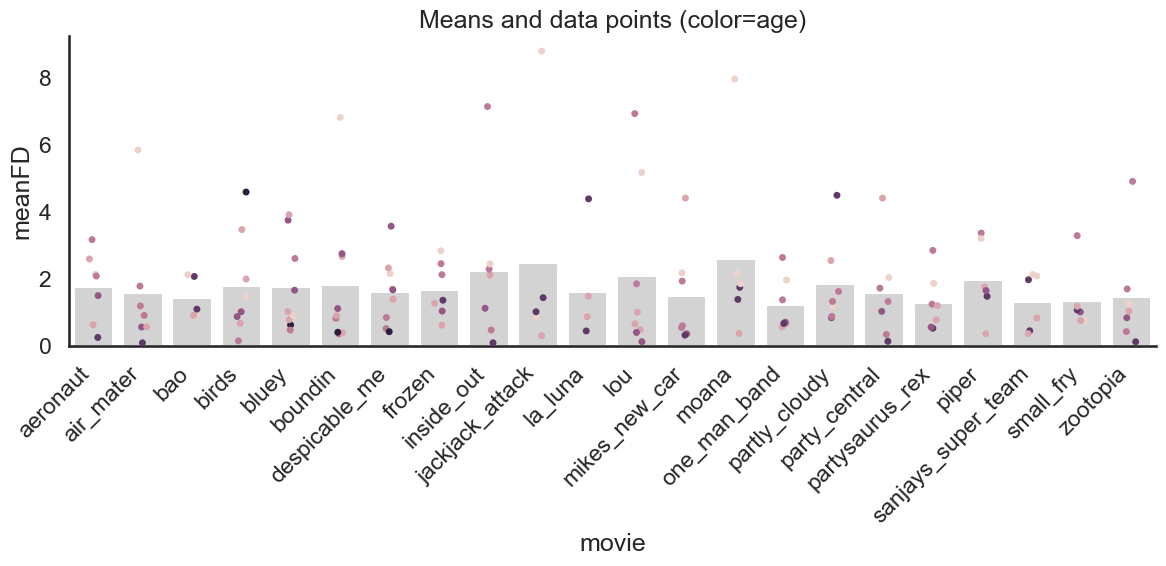

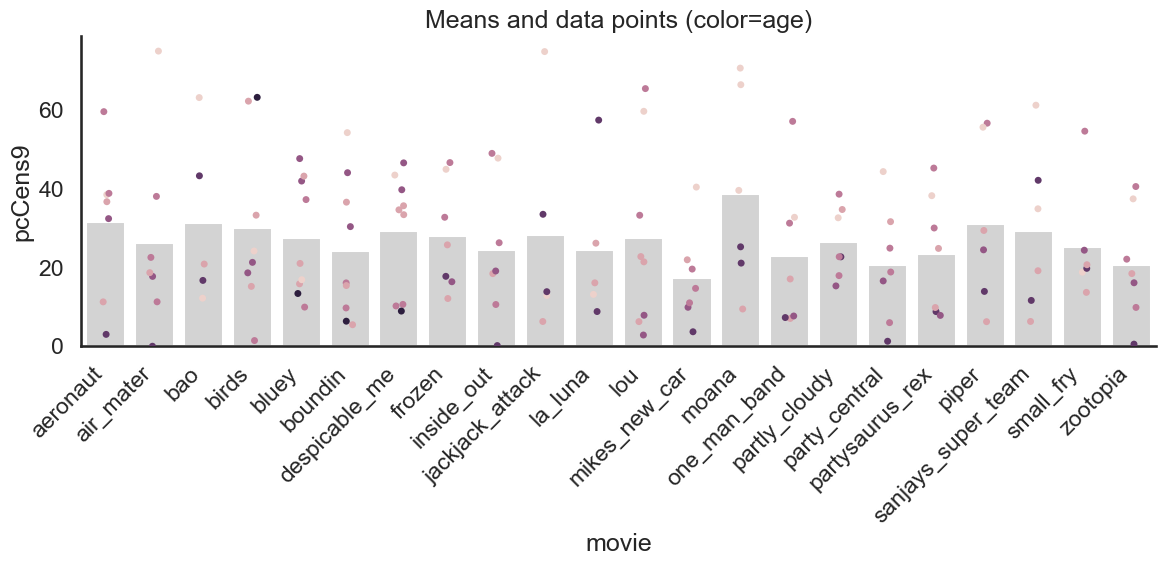

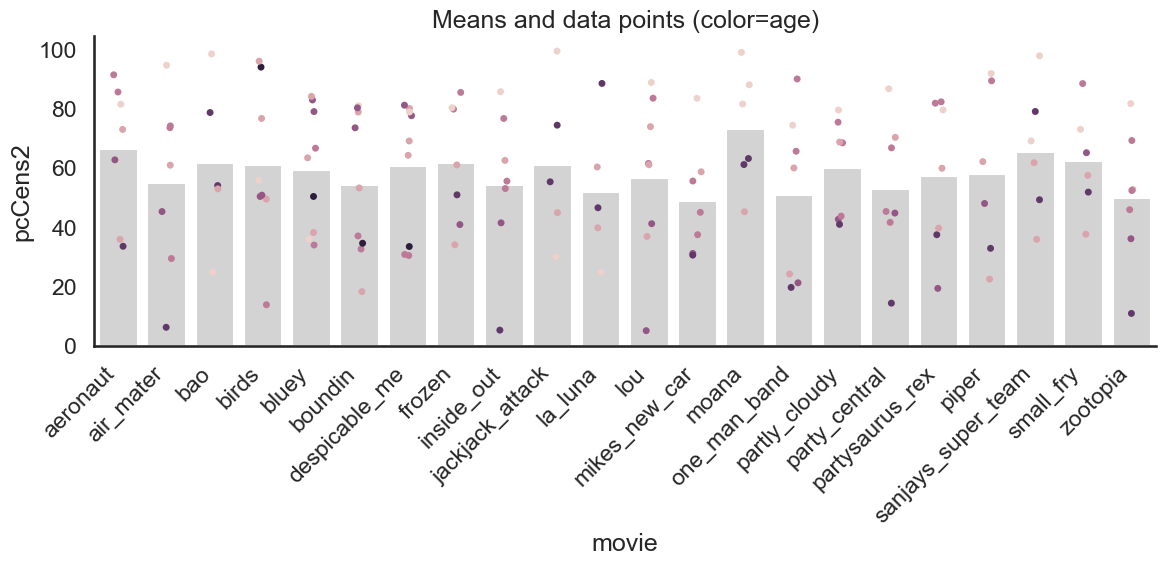

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


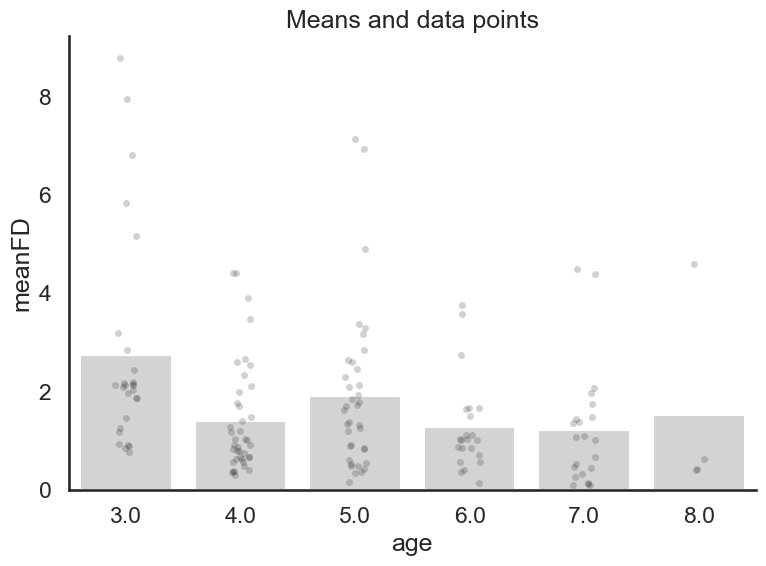

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


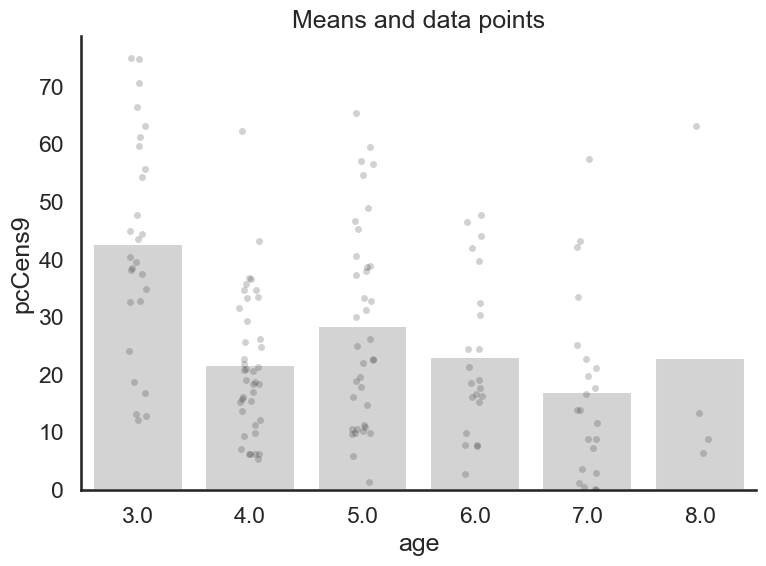

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


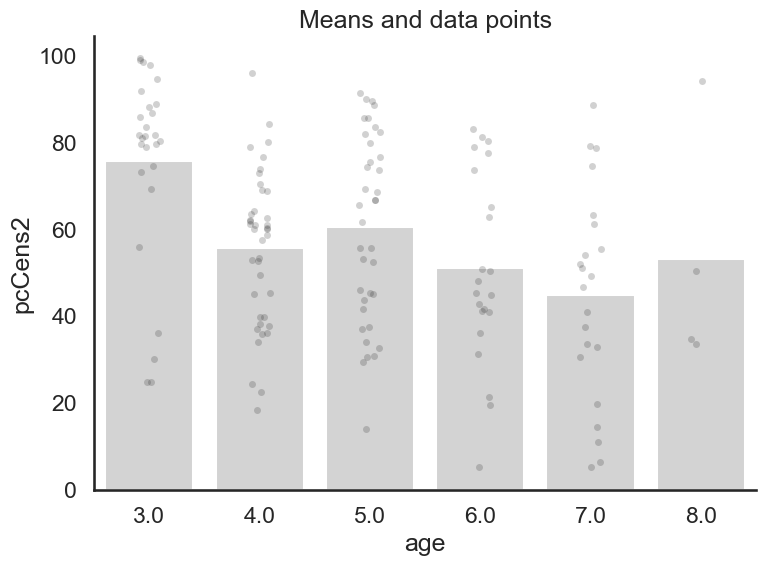

In [47]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data.loc[data['motiongroup']=='high',:], color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data.loc[data['motiongroup']=='high',:], hue='age')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.title('Means and data points (color=age)')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'highmotion_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v, x='age', data=data.loc[data['motiongroup']=='high',:], color='lightgray',errwidth=0)
    sns.stripplot(y=v, x='age', data=data.loc[data['motiongroup']=='high',:], color='k', alpha=0.2)
    plt.legend().remove()
    sns.despine()
    plt.title('Means and data points')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'highmotion_age_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

### raw data plots - full sample

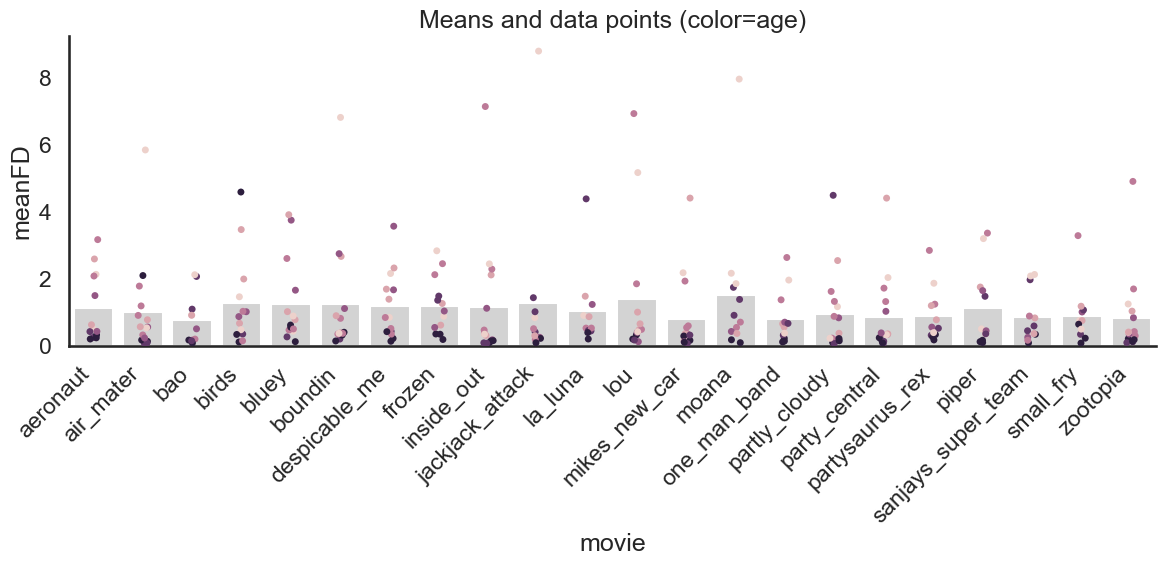

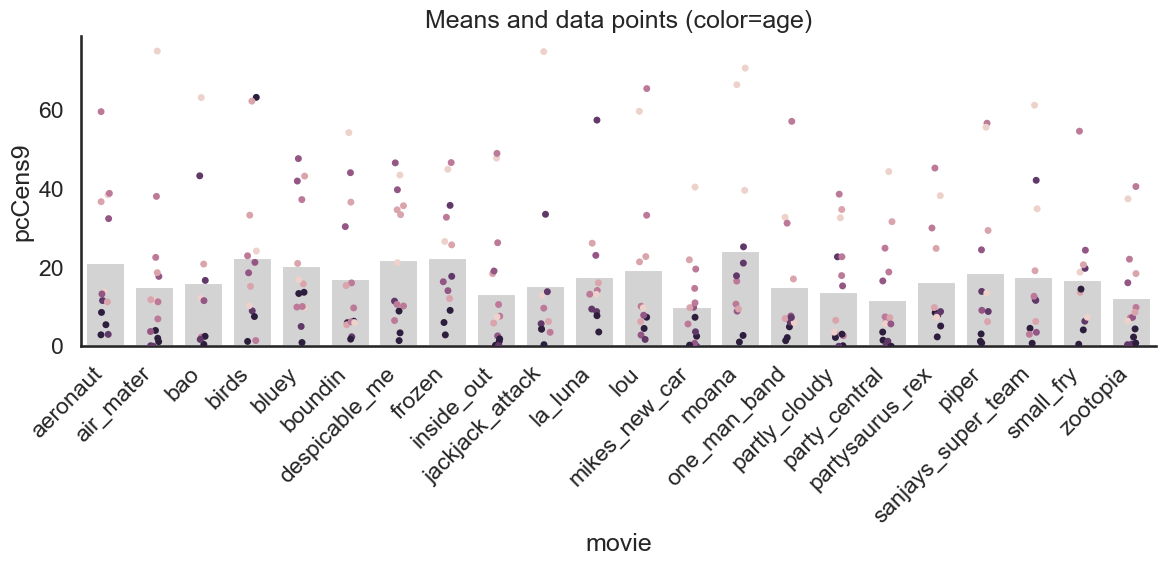

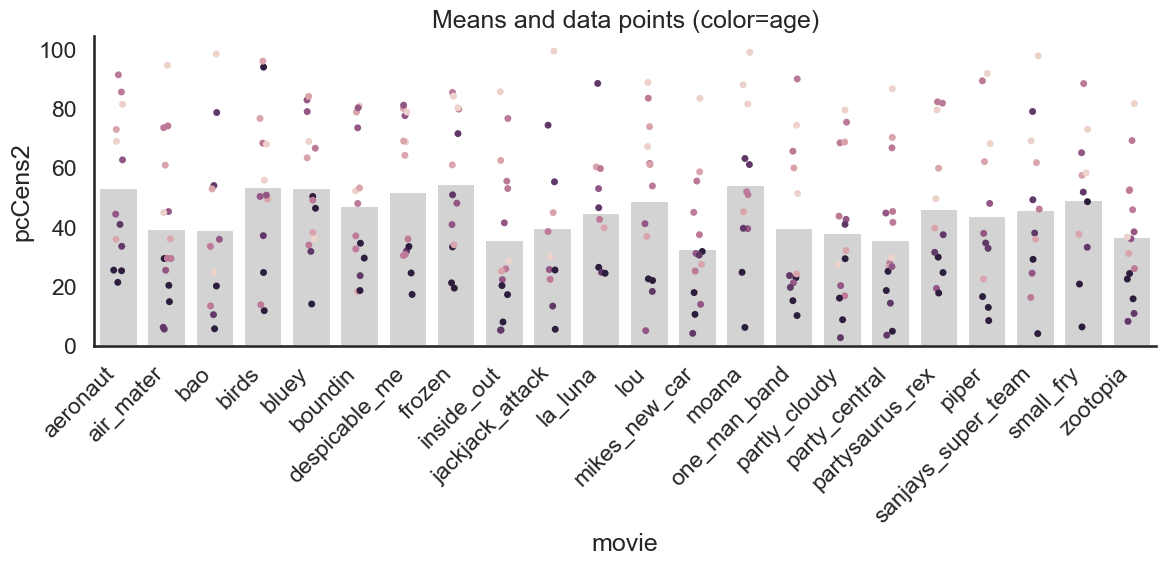

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


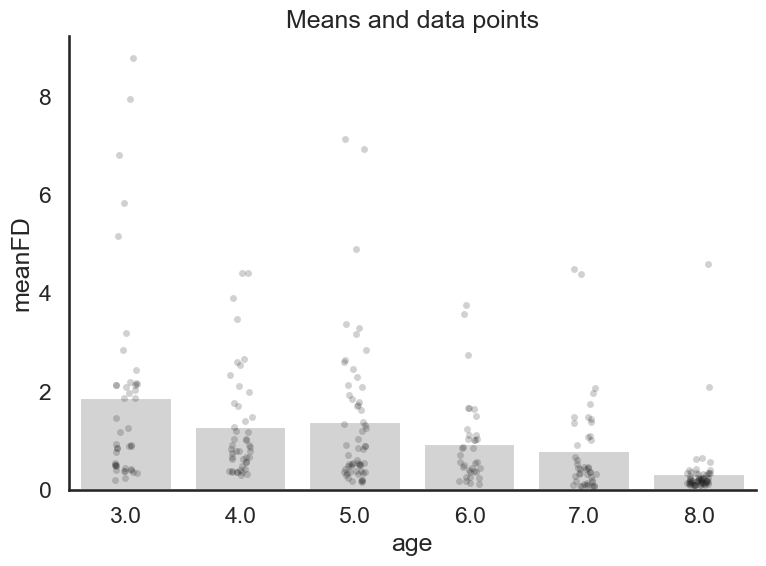

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


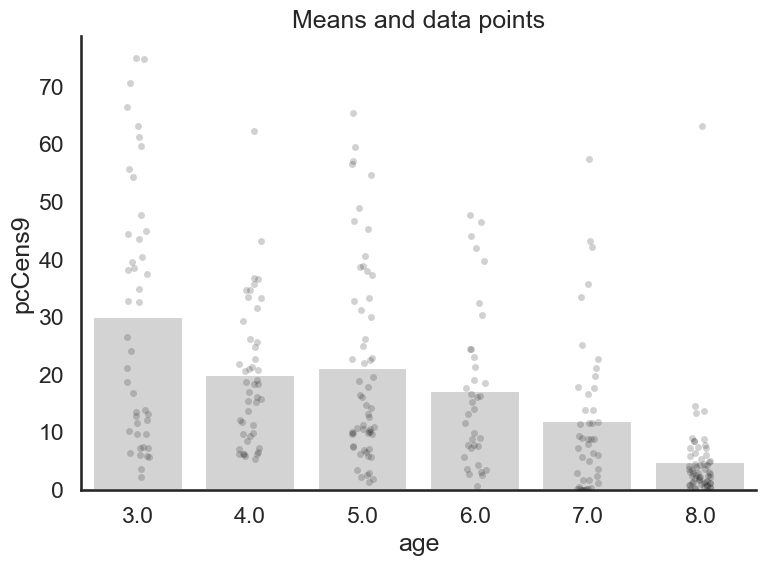

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


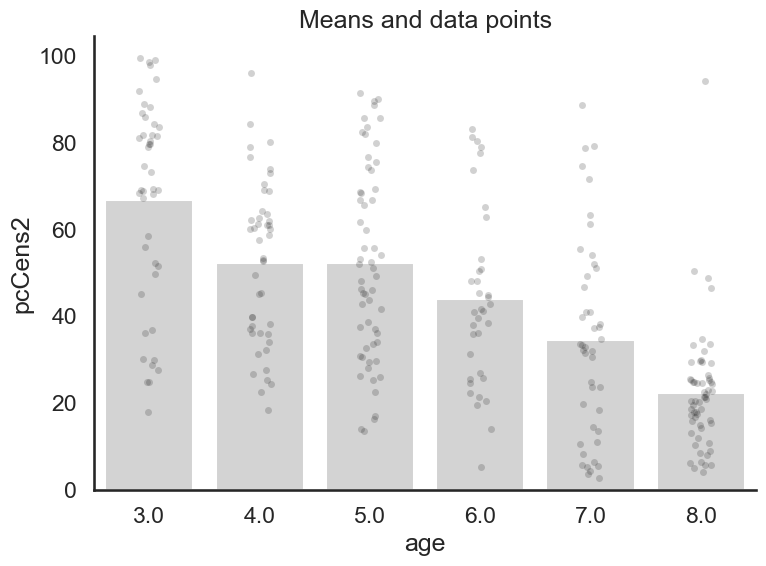

In [48]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data, hue='age')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.title('Means and data points (color=age)')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v, x='age', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v, x='age', data=data, color='k', alpha=0.2)
    plt.legend().remove()
    sns.despine()
    plt.title('Means and data points')
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

### residualized FD plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


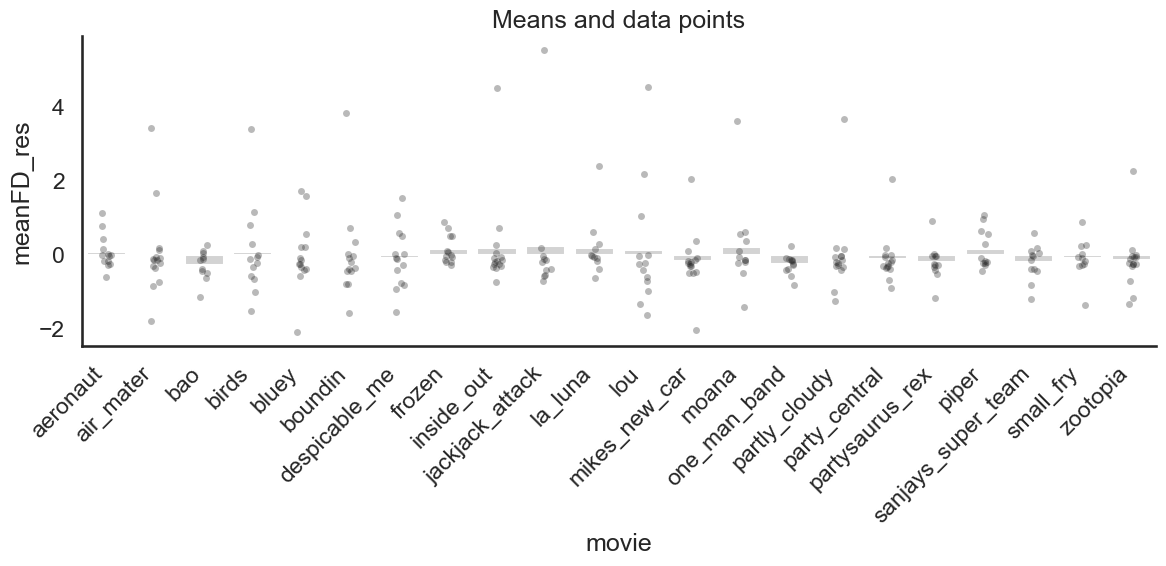

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


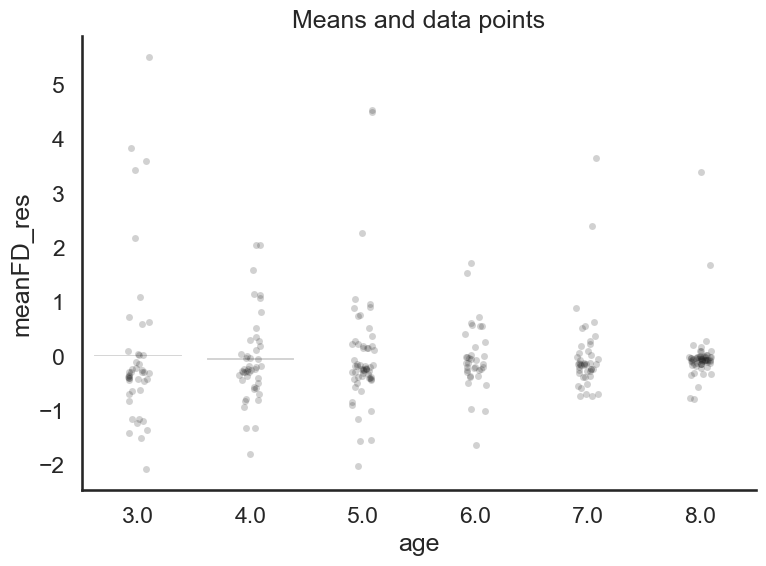

In [22]:
# plot mean FD and proportion of data censored at each 0.9 and 0.2 mm FD
plt.figure(figsize=(12,6))
sns.barplot(y='meanFD_res',x='movie', data=data, color='lightgray',errwidth=0)
sns.stripplot(y='meanFD_res',x='movie', data=data, color='k', alpha=0.3)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.legend().remove()
plt.title('Means and data points')
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, 'fullsample_clip_motion_meanFDres_plot.png'), dpi=200)
plt.show()
plt.close()

plt.figure(figsize=(8,6))
sns.barplot(y='meanFD_res', x='age', data=data, color='lightgray',errwidth=0)
sns.stripplot(y='meanFD_res', x='age', data=data, color='k', alpha=0.2)
plt.legend().remove()
sns.despine()
plt.title('Means and data points')
plt.tight_layout()
plt.savefig(os.path.join(figs_dir, 'fullsample_age_motion_meanFDres_plot.png'), dpi=200)
plt.show()
plt.close()

### analyses of clip category - high motion sample


################### meanFD - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              1.8017   
Min. group size:  1       Log-Likelihood:     -230.4244
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.501    0.782  4.479 0.000  1.969  5.033
human         0.176    0.265  0.663 0.507 -0.343  0.694
age          -0.172    0.115 -1.501 0.133 -0.397  0.053
sex          -0.626    0.352 -1.777 0.076 -1.317  0.064
sub Var       0.599    0.304                           



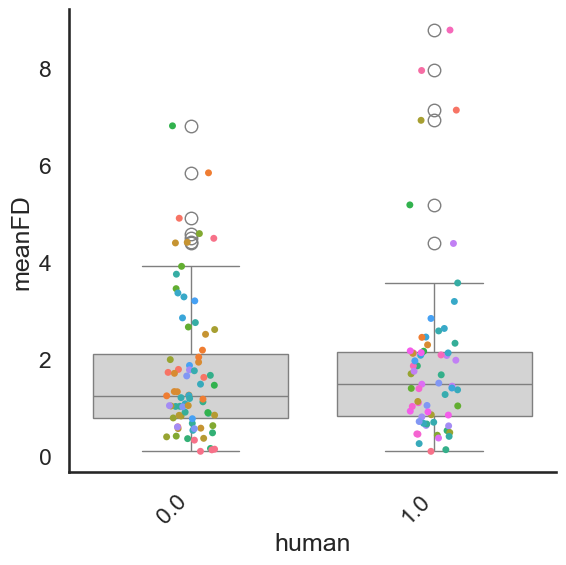


################### meanFD - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              1.7867   
Min. group size:  1       Log-Likelihood:     -229.7166
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.416    0.766  4.458 0.000  1.915  4.918
speaking      0.358    0.260  1.375 0.169 -0.152  0.868
age          -0.175    0.113 -1.548 0.122 -0.398  0.047
sex          -0.657    0.349 -1.880 0.060 -1.341  0.028
sub Var       0.577    0.299                           



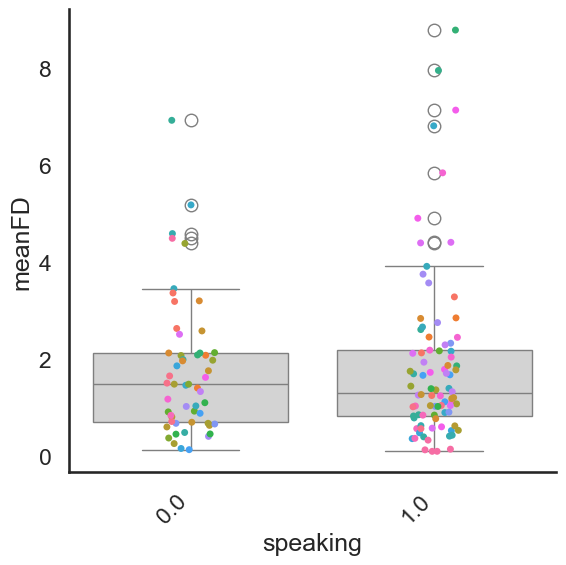


################### meanFD - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              1.8091   
Min. group size:  1       Log-Likelihood:     -230.1229
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.791    0.770  4.924 0.000  2.282  5.301
contained    -0.271    0.284 -0.956 0.339 -0.828  0.285
age          -0.176    0.113 -1.554 0.120 -0.397  0.046
sex          -0.619    0.349 -1.775 0.076 -1.302  0.064
sub Var       0.561    0.292                           



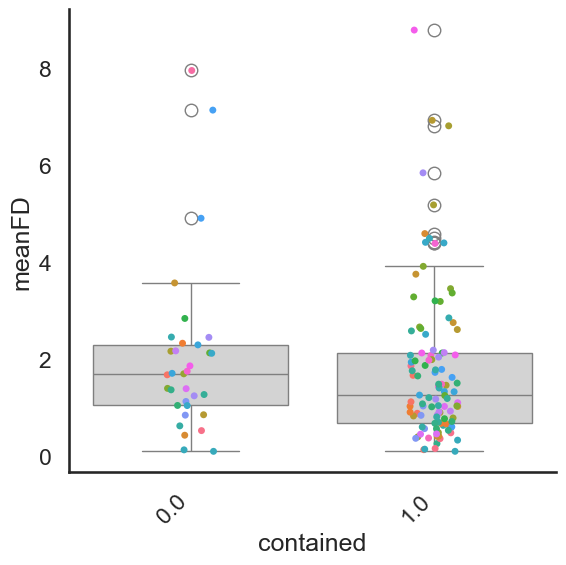


################### pcCens9 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              133.4190 
Min. group size:  1       Log-Likelihood:     -505.2732
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   52.496    9.210  5.700 0.000  34.446 70.547
human        1.502    2.383  0.630 0.529  -3.169  6.173
age         -2.257    1.222 -1.847 0.065  -4.652  0.138
sex         -9.706    3.989 -2.433 0.015 -17.524 -1.888
sub Var    143.620    5.448                            



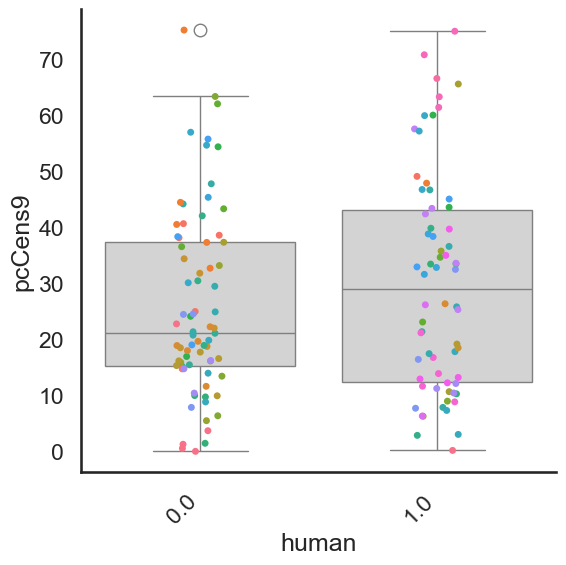


################### pcCens9 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              133.2771 
Min. group size:  1       Log-Likelihood:     -505.3823
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   52.769    9.233  5.715 0.000  34.674 70.865
speaking     1.141    2.299  0.496 0.620  -3.365  5.646
age         -2.293    1.222 -1.876 0.061  -4.688  0.102
sex         -9.766    4.003 -2.440 0.015 -17.612 -1.920
sub Var    145.521    5.507                            



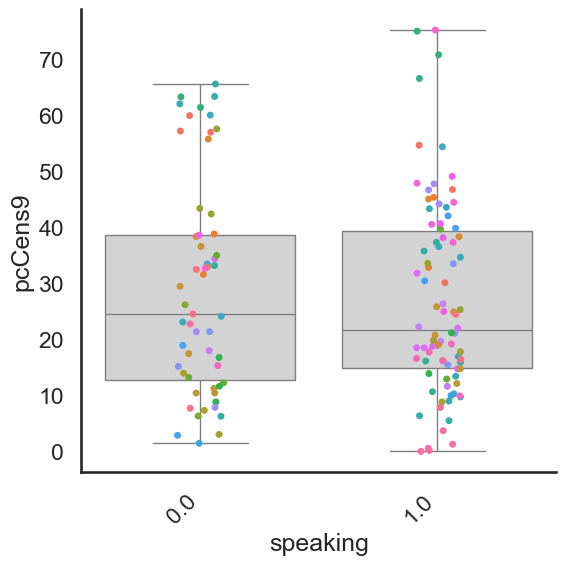


################### pcCens9 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              131.8721 
Min. group size:  1       Log-Likelihood:     -504.7193
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept   54.695    9.179  5.959 0.000  36.705 72.686
contained   -2.938    2.438 -1.205 0.228  -7.716  1.839
age         -2.223    1.220 -1.821 0.069  -4.614  0.169
sex         -9.337    4.016 -2.325 0.020 -17.208 -1.465
sub Var    144.747    5.511                            



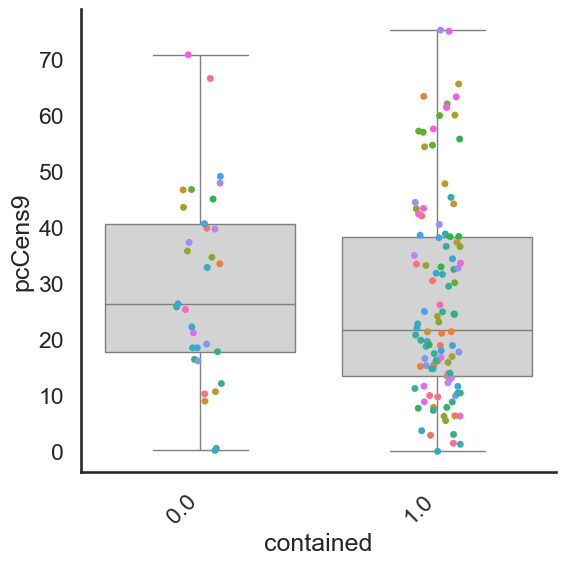


################### pcCens2 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              221.5116 
Min. group size:  1       Log-Likelihood:     -536.5418
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  92.560   11.797  7.846 0.000  69.438 115.683
human       0.232    3.072  0.076 0.940  -5.789   6.253
age        -3.144    1.548 -2.031 0.042  -6.179  -0.110
sex       -12.909    5.189 -2.488 0.013 -23.079  -2.738
sub Var   240.606    6.561                             



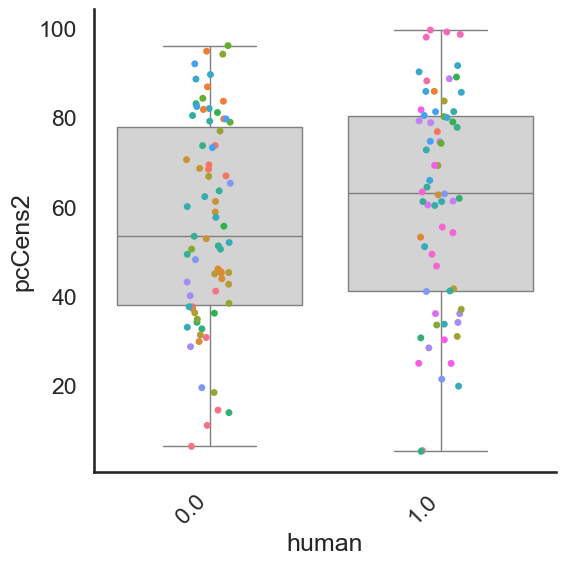


################### pcCens2 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              217.9729 
Min. group size:  1       Log-Likelihood:     -535.8910
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  90.058   11.849  7.601 0.000  66.835 113.280
speaking    3.465    2.943  1.177 0.239  -2.303   9.232
age        -3.044    1.545 -1.971 0.049  -6.071  -0.017
sex       -12.972    5.191 -2.499 0.012 -23.147  -2.798
sub Var   244.150    6.687                             



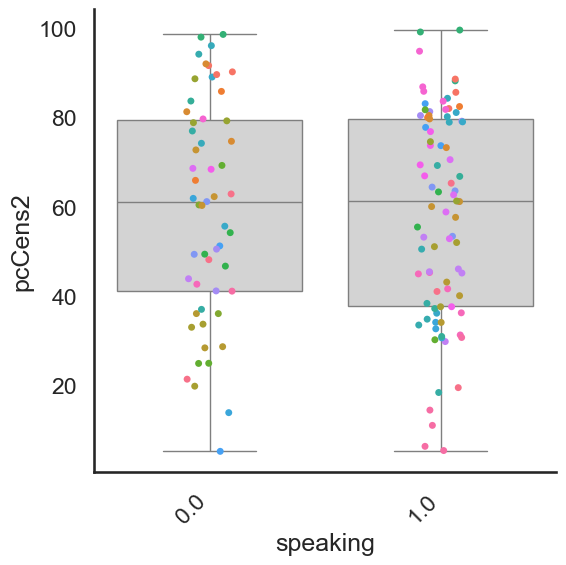


################### pcCens2 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2  
No. Observations: 127     Method:             REML     
No. Groups:       26      Scale:              219.2698 
Min. group size:  1       Log-Likelihood:     -536.0401
Max. group size:  6       Converged:          Yes      
Mean group size:  4.9                                  
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept  93.825   11.718  8.007 0.000  70.858 116.792
contained  -3.070    3.143 -0.977 0.329  -9.229   3.090
age        -3.045    1.545 -1.970 0.049  -6.074  -0.016
sex       -12.481    5.222 -2.390 0.017 -22.716  -2.245
sub Var   241.885    6.624                             



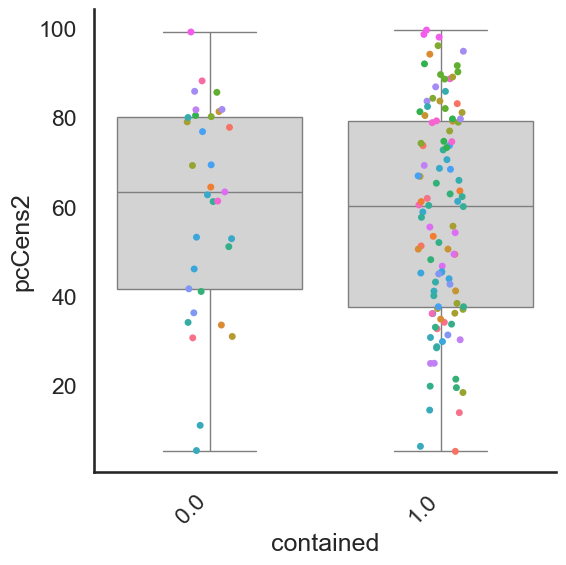

In [92]:
for v in ['meanFD','pcCens9','pcCens2']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1} + age + sex'.format(v,f), groups='sub', 
                          data=temp.loc[temp['motiongroup']=='high',:]).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.boxplot(y=v,x=f, data=data.loc[data['motiongroup']=='high',:], color='lightgray')
        sns.stripplot(y=v,x=f, data=data.loc[data['motiongroup']=='high',:], hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'highsample_feature_{0}_motion_{1}_plot.png'.format(f,v)), 
                    dpi=200)
        plt.show()
        plt.close()

### analyses of clip category - full sample


################### meanFD - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8870   
Min. group size:  1       Log-Likelihood:     -383.0418
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.971    0.540  5.505 0.000  1.913  4.029
human         0.060    0.141  0.425 0.671 -0.217  0.337
age          -0.221    0.064 -3.477 0.001 -0.346 -0.097
sex          -0.424    0.216 -1.959 0.050 -0.848  0.000
sub Var       0.764    0.296                           



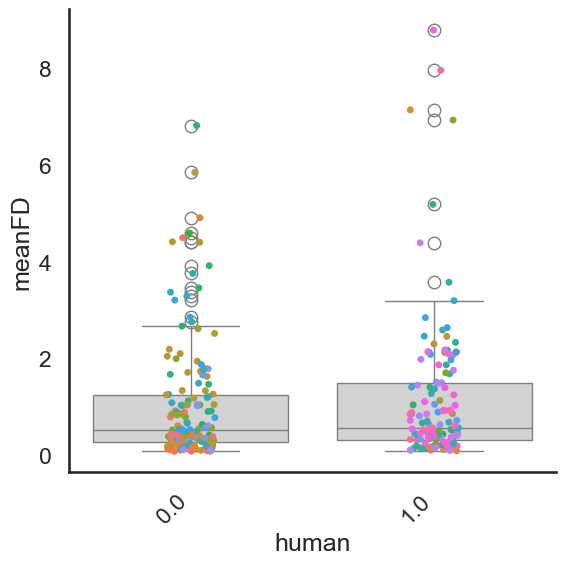


################### meanFD - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8804   
Min. group size:  1       Log-Likelihood:     -382.1702
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.878    0.538  5.346 0.000  1.823  3.933
speaking      0.189    0.132  1.438 0.150 -0.069  0.447
age          -0.225    0.063 -3.583 0.000 -0.348 -0.102
sex          -0.407    0.216 -1.885 0.059 -0.830  0.016
sub Var       0.757    0.293                           



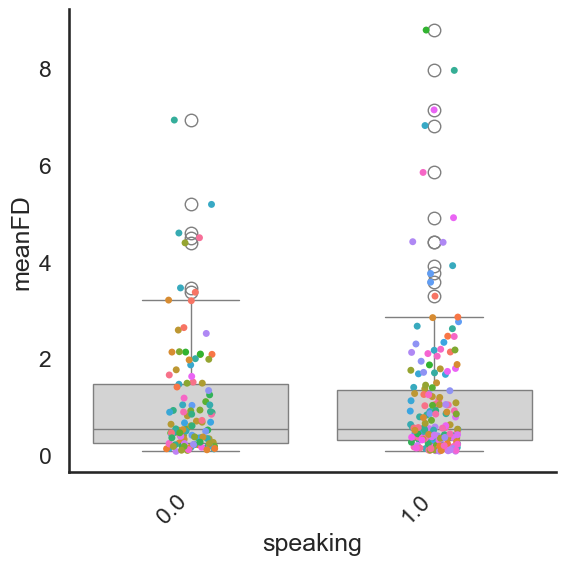


################### meanFD - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: meanFD   
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              0.8857   
Min. group size:  1       Log-Likelihood:     -382.5689
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     3.128    0.542  5.768 0.000  2.065  4.190
contained    -0.150    0.142 -1.061 0.289 -0.428  0.127
age          -0.223    0.063 -3.537 0.000 -0.346 -0.099
sex          -0.429    0.215 -1.992 0.046 -0.851 -0.007
sub Var       0.751    0.291                           



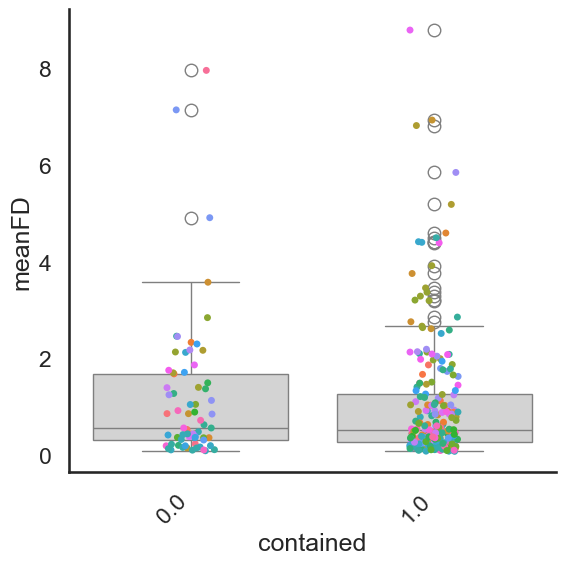


################### pcCens9 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              74.1106  
Min. group size:  1       Log-Likelihood:     -946.1515
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    39.480    6.190  6.378 0.000 27.348 51.612
human         0.472    1.332  0.354 0.723 -2.140  3.083
age          -2.682    0.703 -3.816 0.000 -4.059 -1.304
sex          -4.680    2.372 -1.973 0.049 -9.330 -0.030
sub Var     160.949    5.323                           



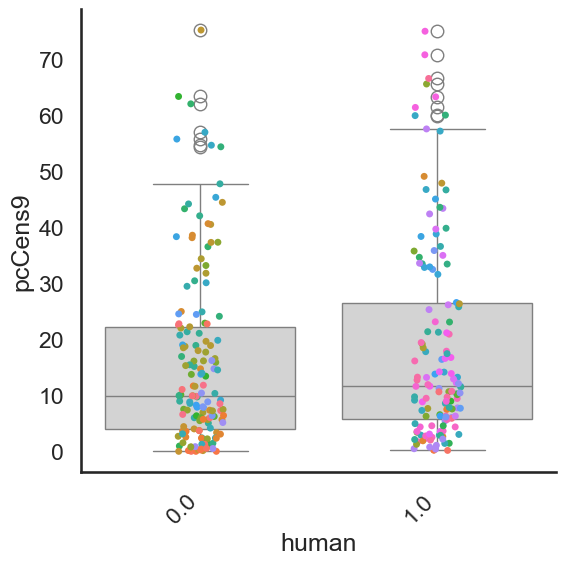


################### pcCens9 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              73.9440  
Min. group size:  1       Log-Likelihood:     -946.0481
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    39.124    6.191  6.319 0.000 26.989 51.259
speaking      0.869    1.219  0.712 0.476 -1.521  3.258
age          -2.717    0.695 -3.911 0.000 -4.078 -1.355
sex          -4.520    2.373 -1.905 0.057 -9.171  0.131
sub Var     161.229    5.327                           



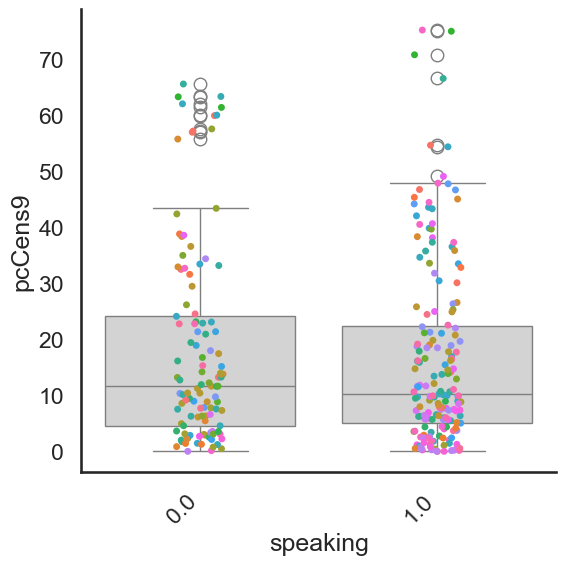


################### pcCens9 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens9  
No. Observations: 250     Method:             REML     
No. Groups:       49      Scale:              72.9257  
Min. group size:  1       Log-Likelihood:     -944.4789
Max. group size:  6       Converged:          Yes      
Mean group size:  5.1                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    41.454    6.164  6.725 0.000 29.373 53.536
contained    -2.425    1.287 -1.884 0.060 -4.948  0.098
age          -2.646    0.693 -3.819 0.000 -4.004 -1.288
sex          -4.759    2.354 -2.021 0.043 -9.373 -0.144
sub Var     160.472    5.330                           



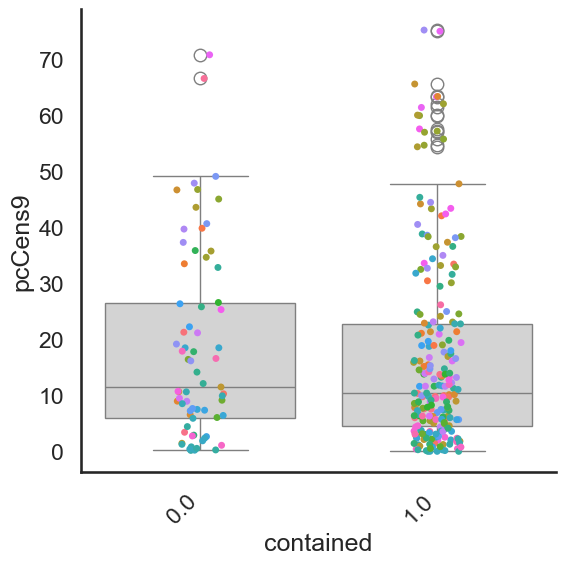


################### pcCens2 - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 250     Method:             REML      
No. Groups:       49      Scale:              152.1951  
Min. group size:  1       Log-Likelihood:     -1034.1880
Max. group size:  6       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    75.146    9.000  8.349 0.000  57.505 92.786
human        -1.038    1.908 -0.544 0.586  -4.777  2.701
age          -3.913    1.053 -3.716 0.000  -5.976 -1.849
sex          -5.117    3.350 -1.527 0.127 -11.684  1.450
sub Var     323.302    7.469                            



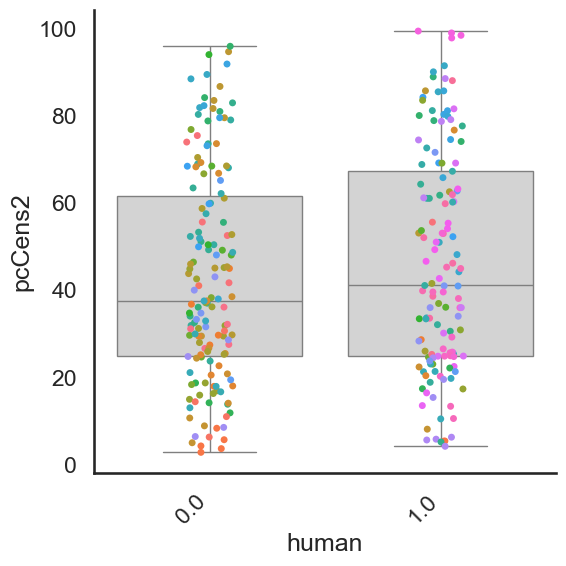


################### pcCens2 - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 250     Method:             REML      
No. Groups:       49      Scale:              150.7896  
Min. group size:  1       Log-Likelihood:     -1033.5112
Max. group size:  6       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    72.323    9.016  8.022 0.000  54.653 89.994
speaking      2.358    1.741  1.354 0.176  -1.055  5.771
age          -3.809    1.043 -3.652 0.000  -5.854 -1.765
sex          -4.928    3.349 -1.472 0.141 -11.491  1.635
sub Var     325.988    7.571                            



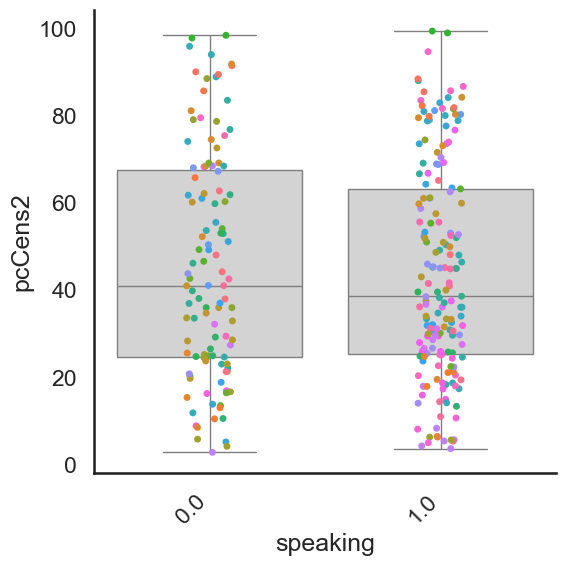


################### pcCens2 - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pcCens2   
No. Observations: 250     Method:             REML      
No. Groups:       49      Scale:              149.9427  
Min. group size:  1       Log-Likelihood:     -1032.9232
Max. group size:  6       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept    76.298    8.968  8.508 0.000  58.721 93.875
contained    -3.144    1.845 -1.704 0.088  -6.761  0.473
age          -3.712    1.045 -3.552 0.000  -5.761 -1.664
sex          -5.385    3.331 -1.617 0.106 -11.914  1.144
sub Var     326.661    7.607                            



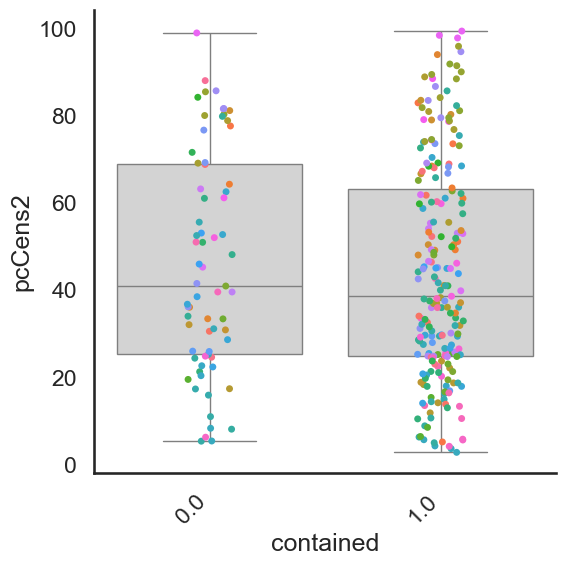

In [35]:
for v in ['meanFD','pcCens9','pcCens2']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1} + age + sex'.format(v,f), groups='sub', data=temp).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.boxplot(y=v,x=f, data=data, color='lightgray')
        sns.stripplot(y=v,x=f, data=data, hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'fullsample_feature_{0}_motion_{1}_plot.png'.format(f,v)), dpi=200)
        plt.show()
        plt.close()
        
        

# Plots by age group - full sample

## 3-4 year olds

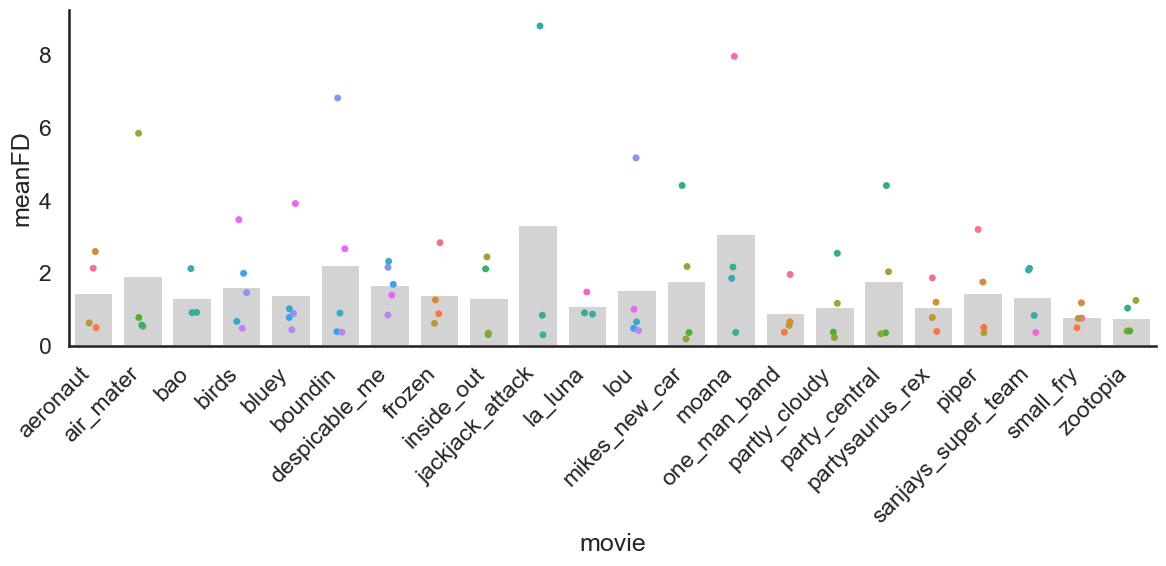

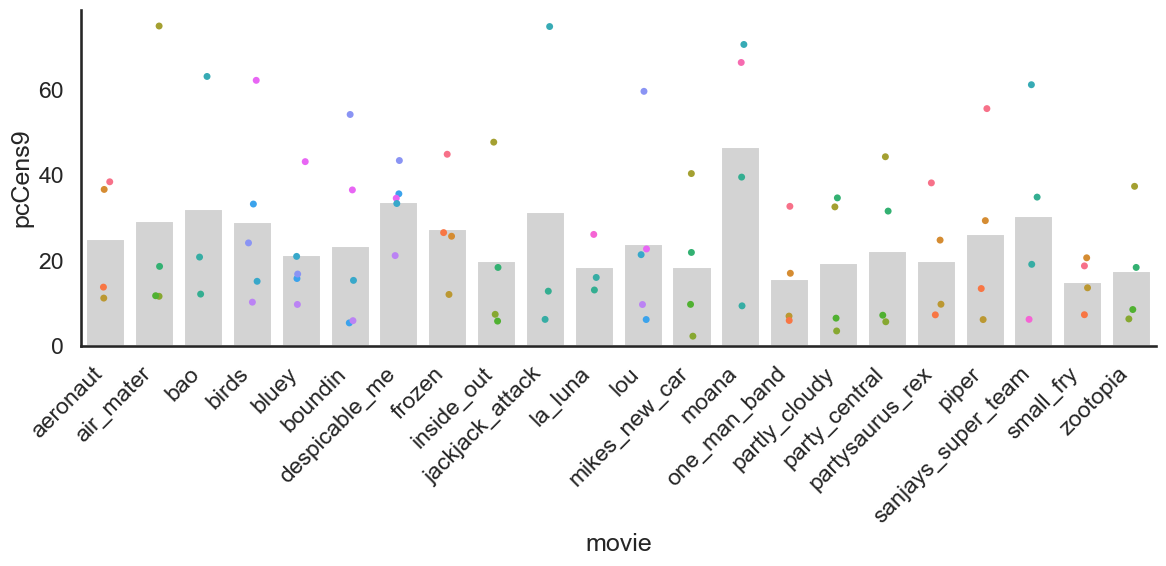

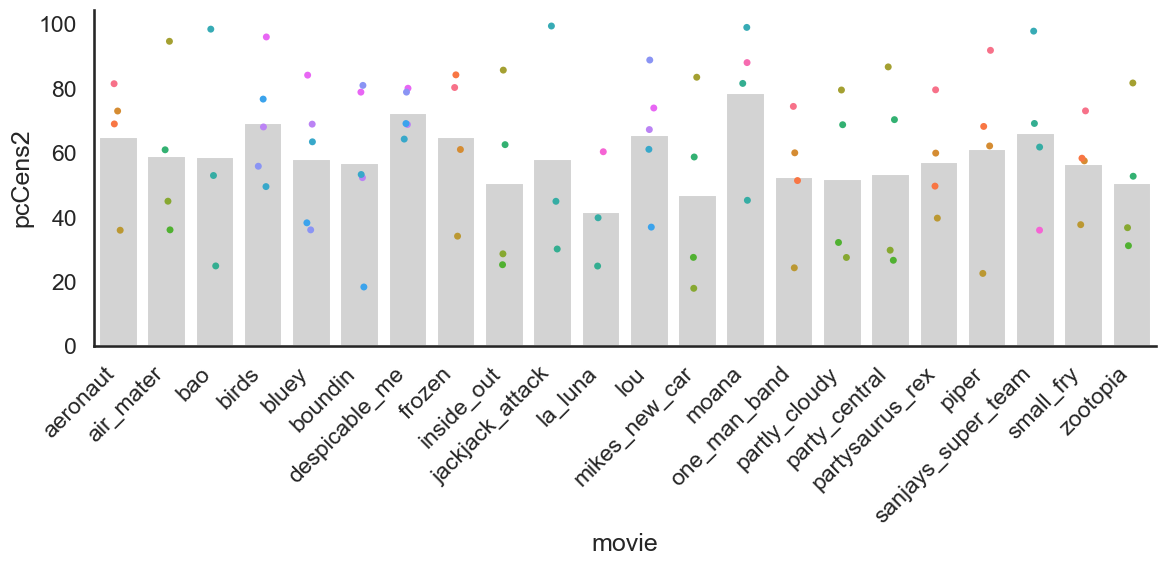

In [49]:
tempdata = data.loc[data['age']<5,:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages34_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

## 5-6 year olds

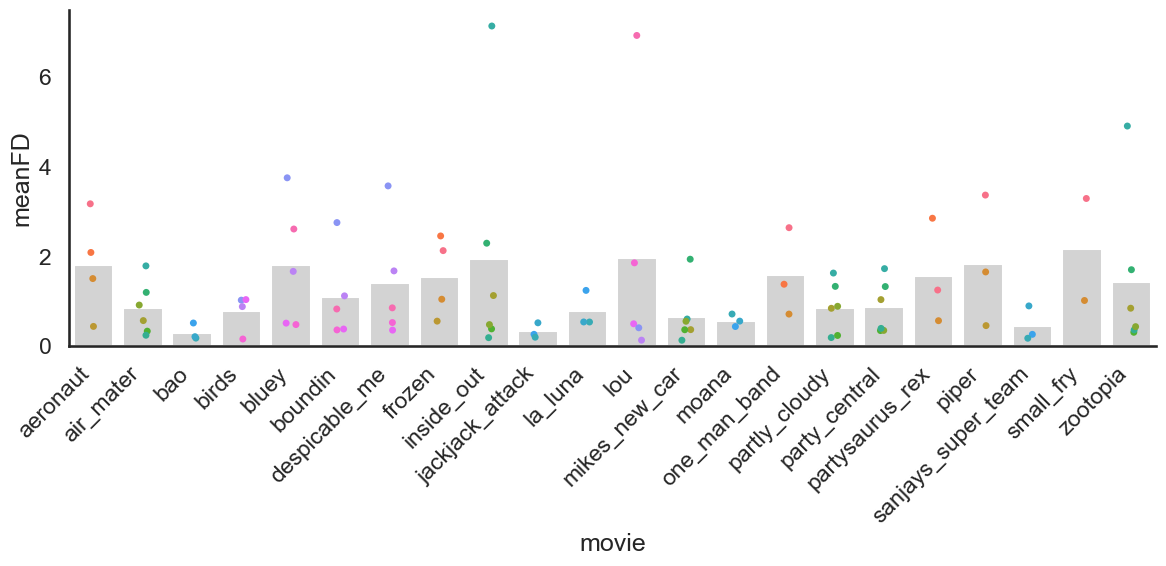

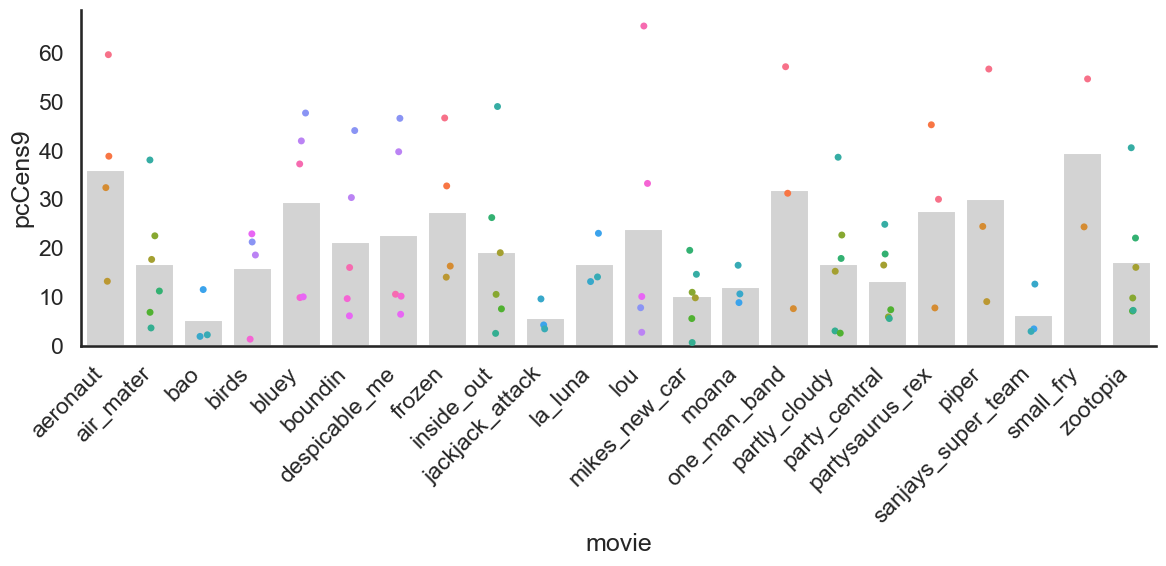

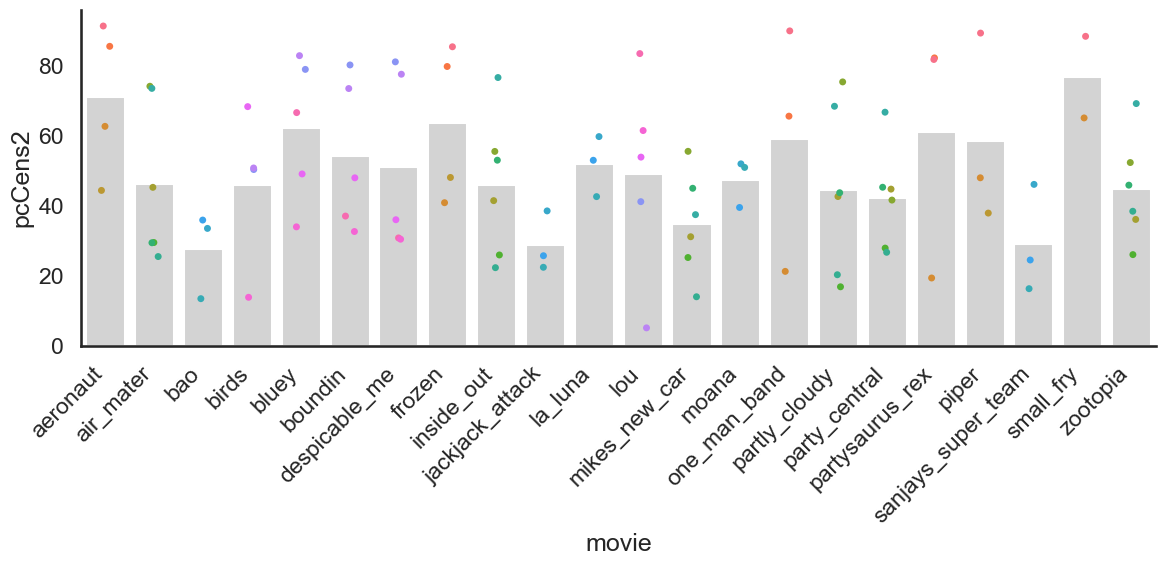

In [50]:
tempdata = data.loc[(data['age']==5) | (data['age']==6),:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages56_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

## 7-8 year olds

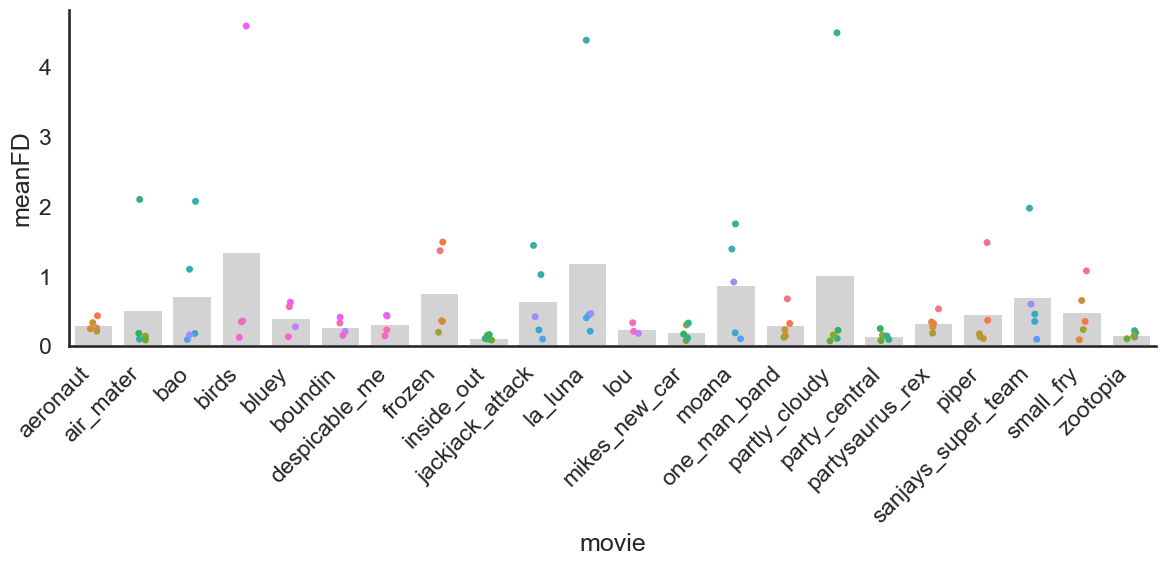

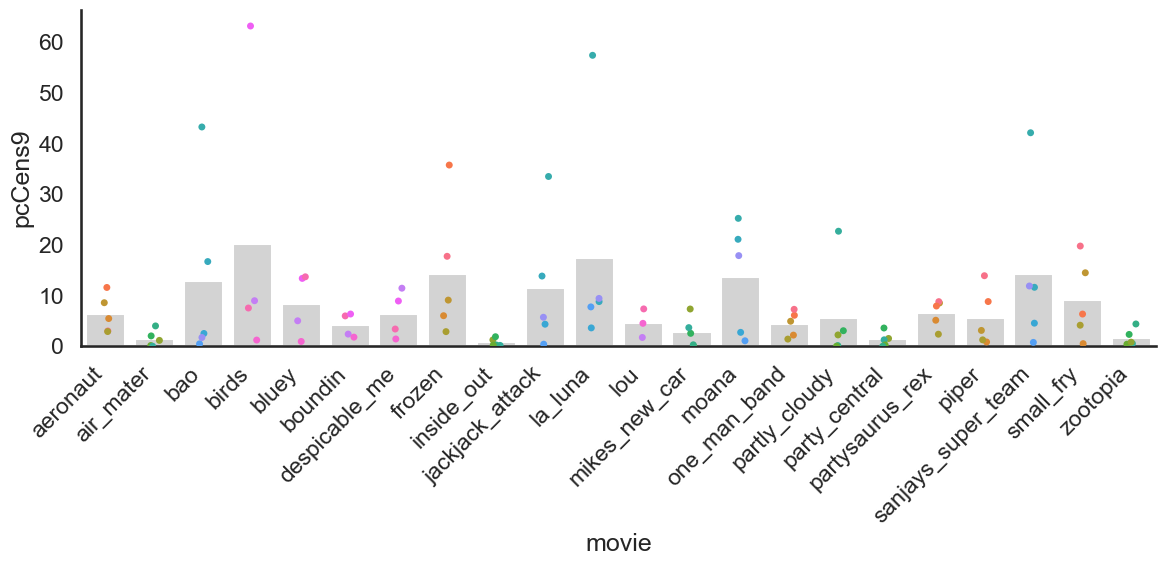

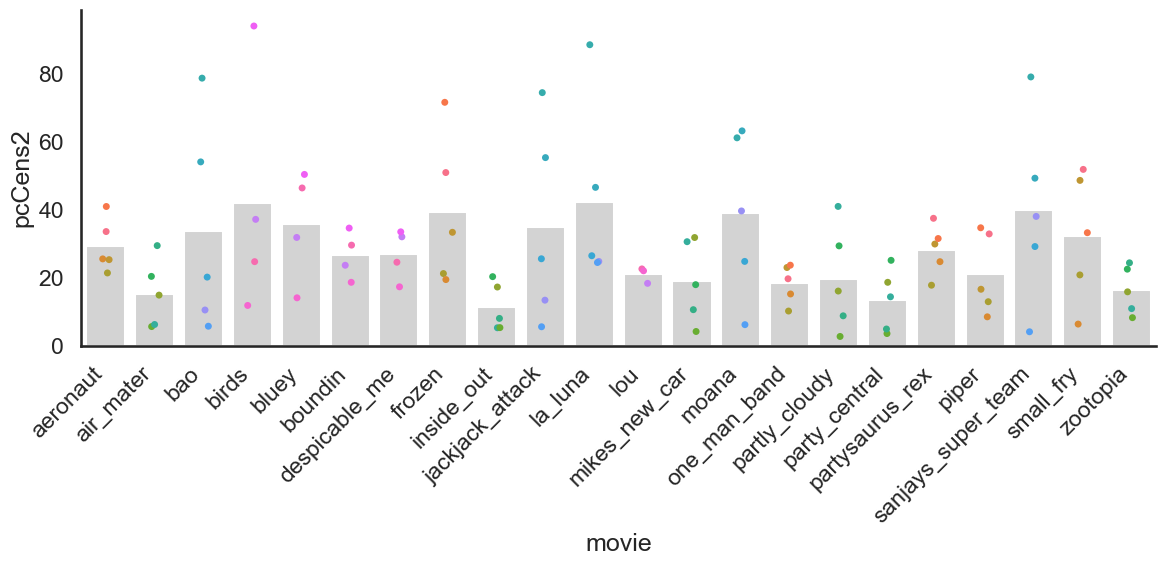

In [51]:
tempdata = data.loc[(data['age']==7) | (data['age']==8),:].copy()

# plot mean FD

for v in ['meanFD','pcCens9','pcCens2']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=tempdata, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=tempdata, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'ages78_clip_motion_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

# get timeseries of motion across clips

In [52]:
clipmotion = {}
for mov in clipinfo.index:
    clipmotion[mov] = pd.DataFrame(index=range(0,3001))

In [53]:
for sub in subs:
    print(sub)
    subdata = pd.read_csv(os.path.join(data_dir, sub, '{0}_motion_data_processed.csv'.format(sub)), index_col=0)
    clips = np.unique(subdata['title'].dropna())
    for clip in clips:
        temp = subdata.loc[subdata['title']==clip,'FD50'].to_numpy()
        clipmotion[clip].loc[:temp.shape[0]-1,sub] = temp
        

2002
2003
2004
2005
2006
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2042
2043
2044
2045
2046
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2063
2065


In [54]:
for mov in clipinfo.index:
    clipmotion[mov] = clipmotion[mov].dropna(axis=0,how='all')

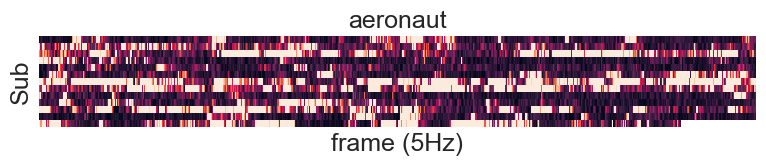

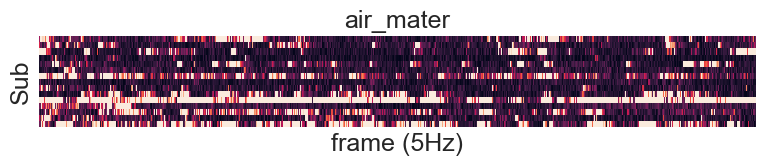

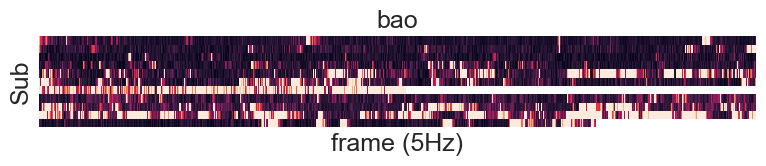

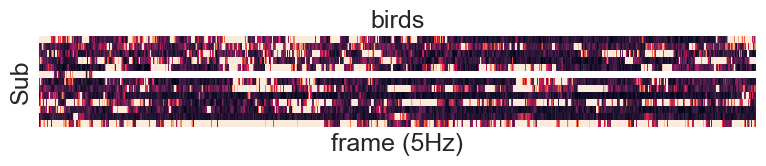

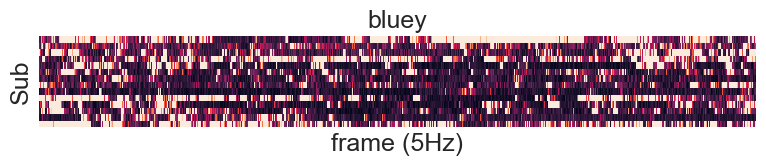

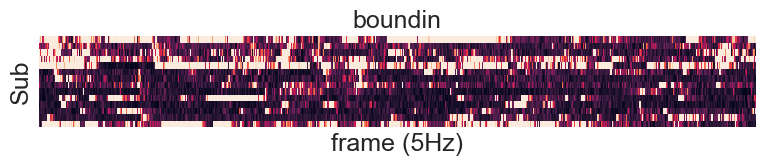

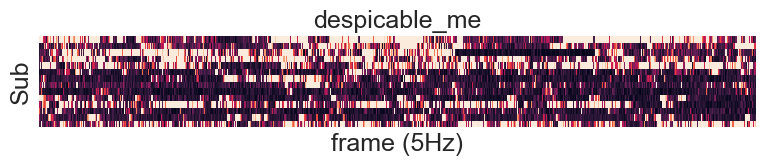

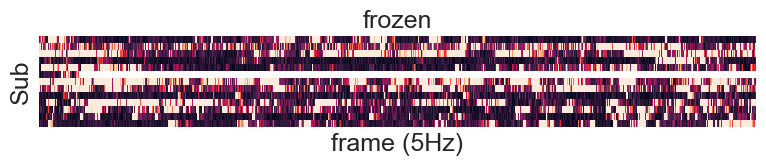

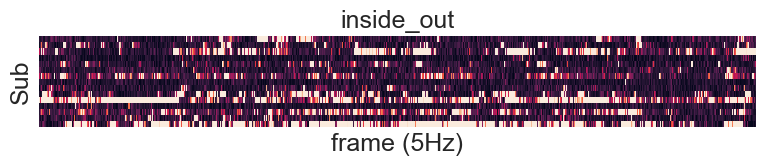

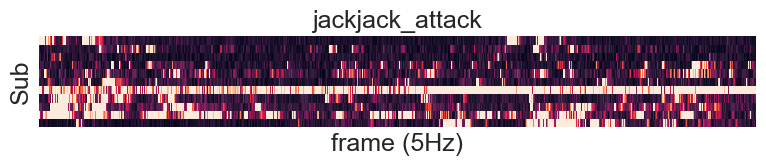

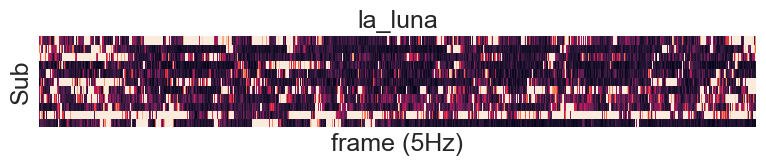

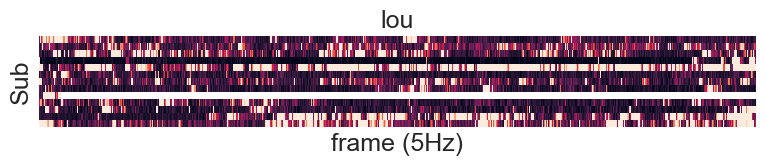

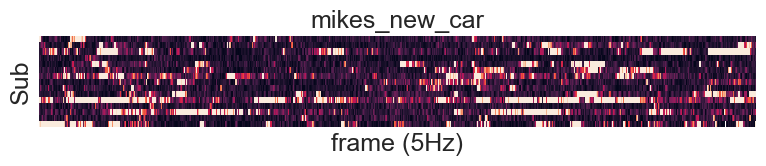

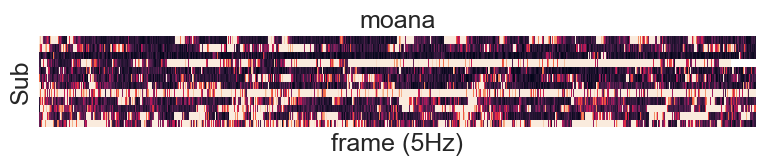

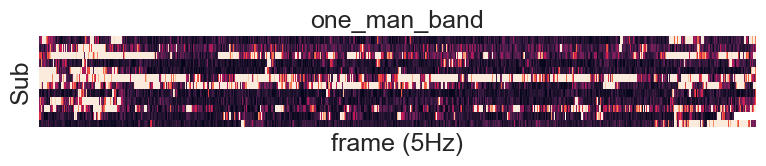

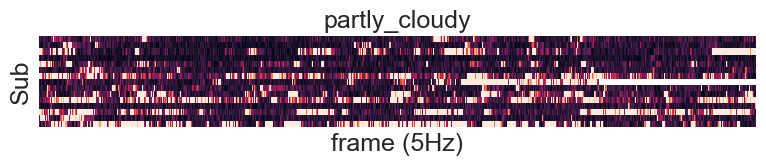

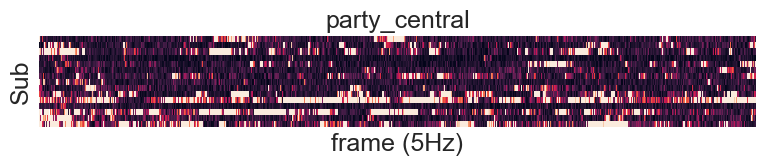

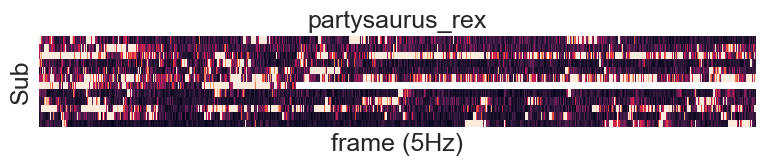

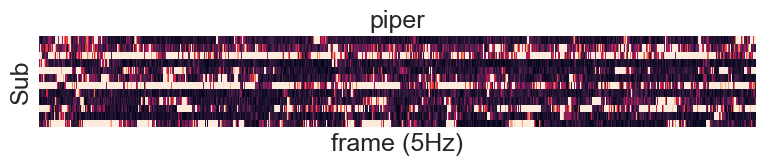

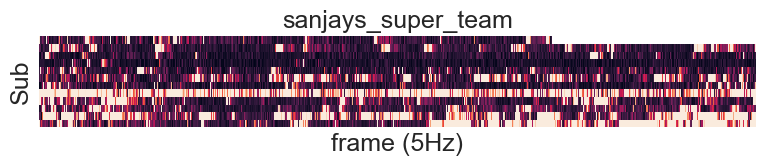

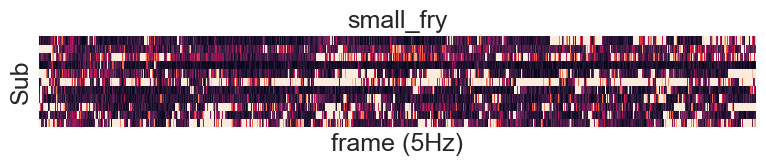

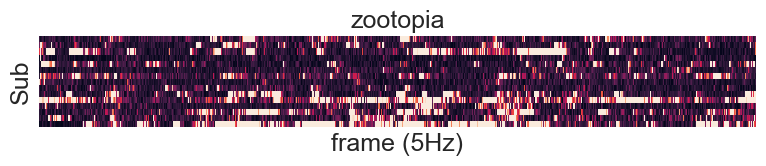

In [55]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_FD_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

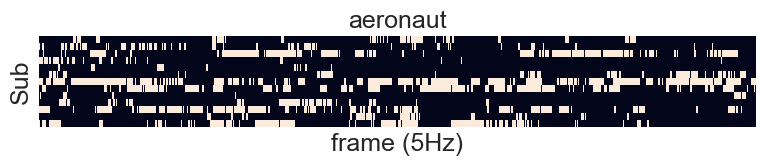

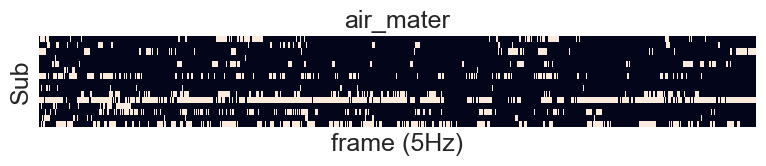

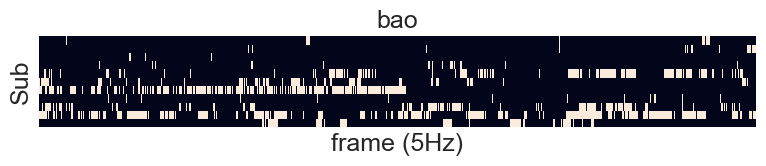

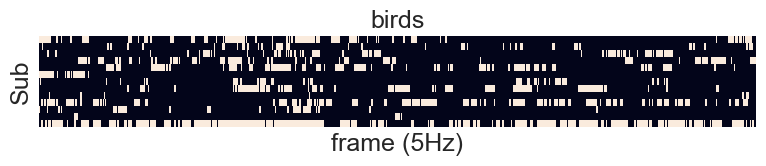

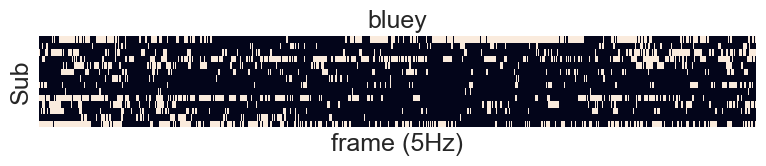

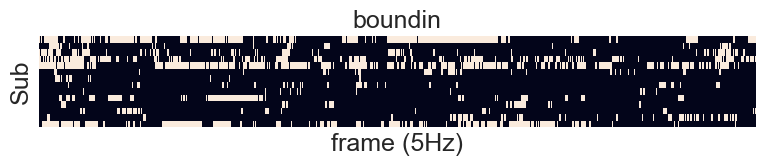

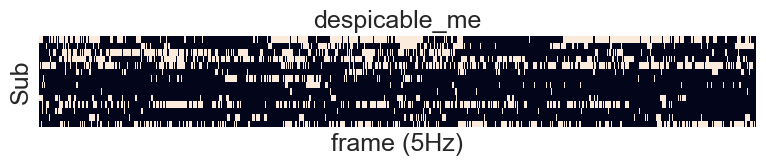

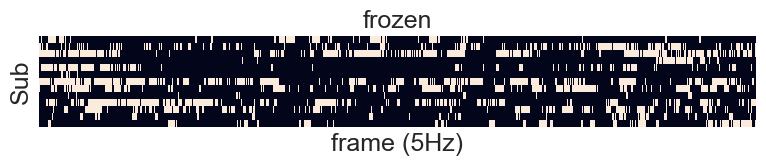

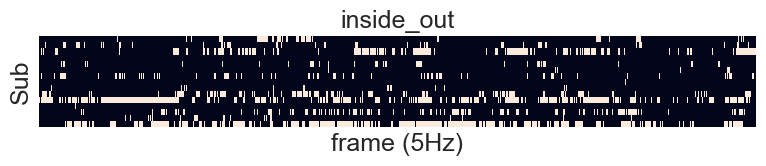

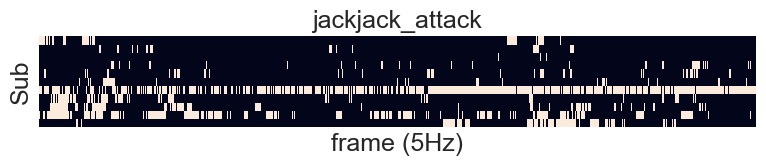

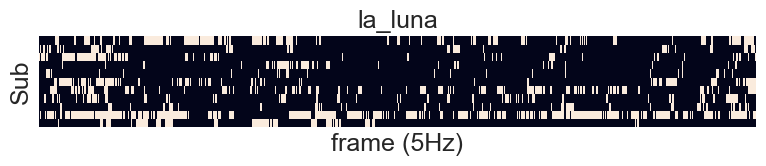

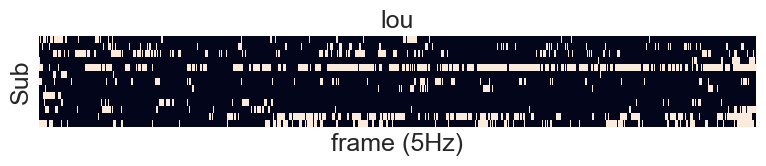

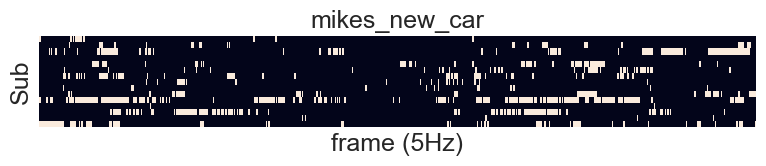

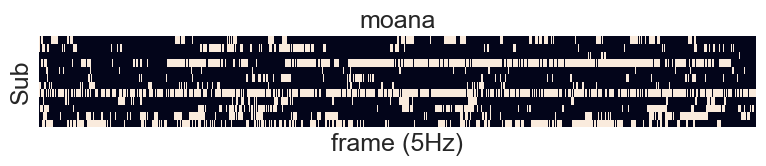

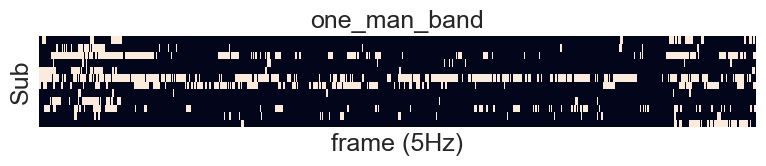

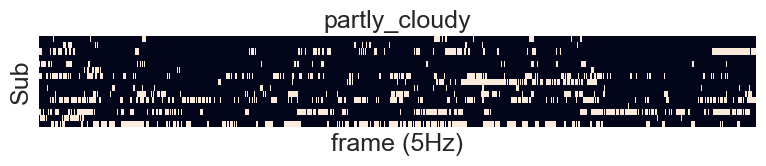

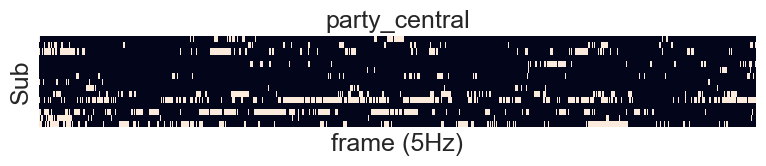

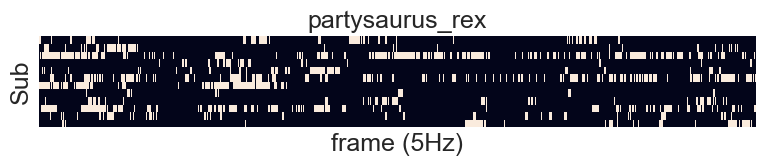

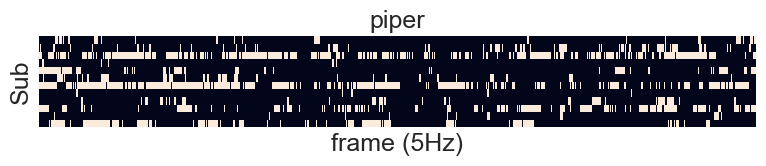

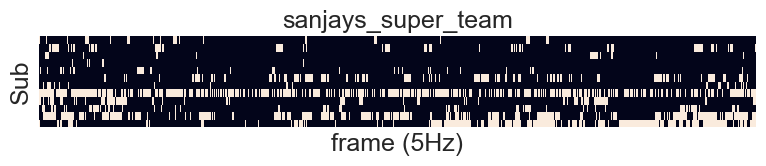

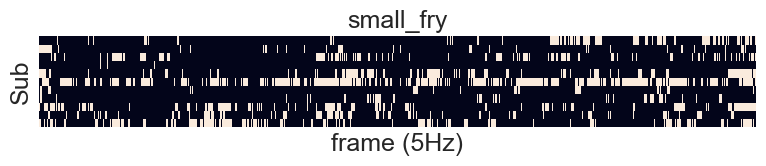

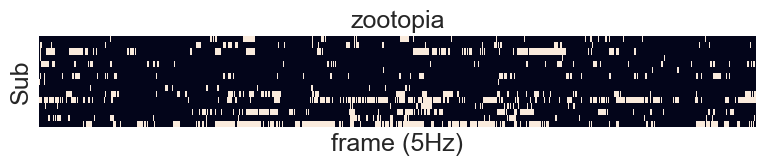

In [56]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T>0.9, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_cens09_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

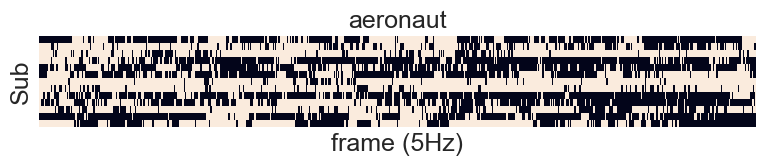

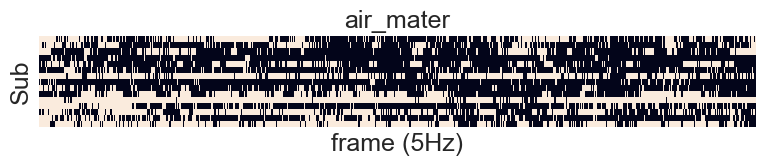

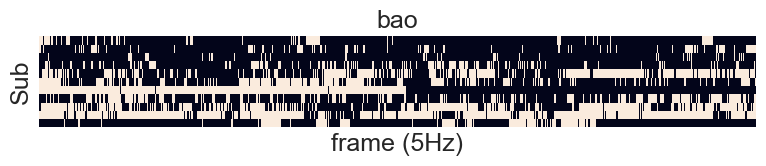

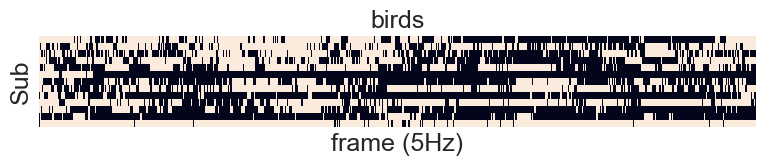

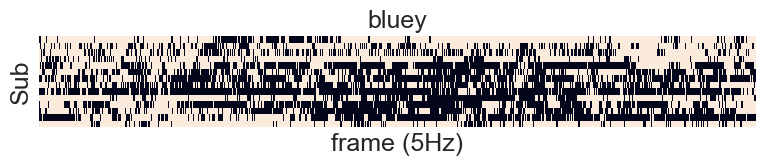

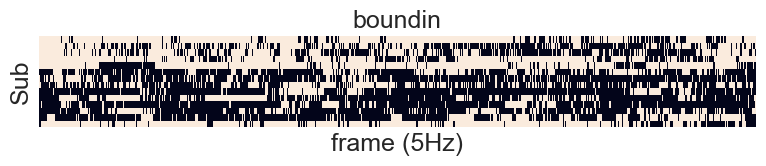

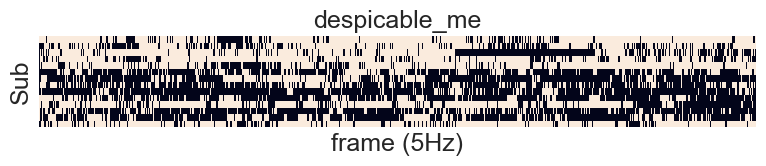

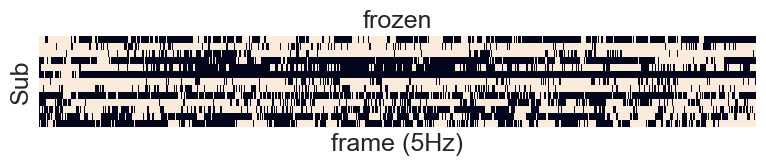

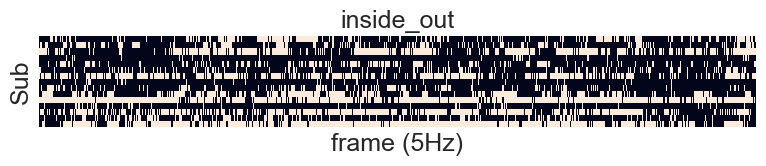

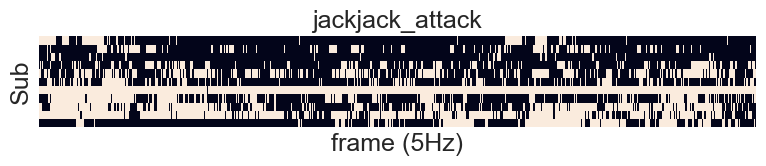

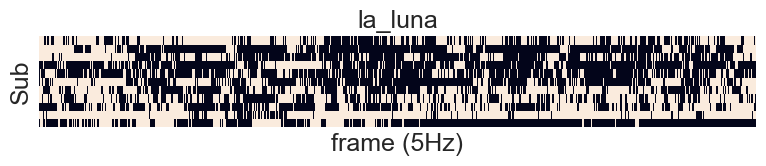

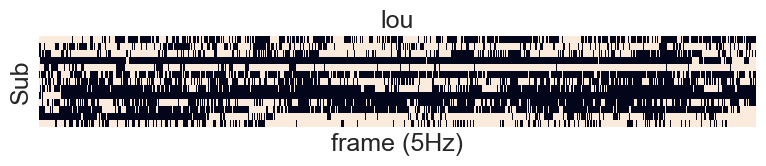

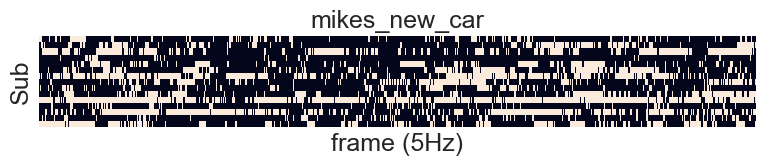

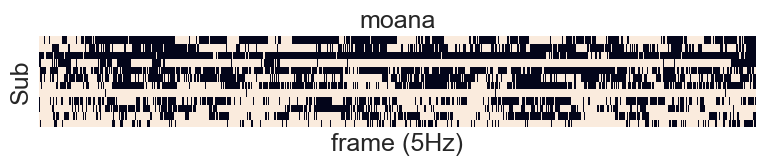

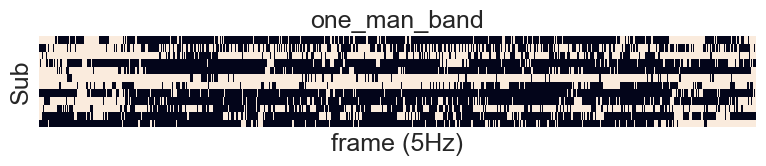

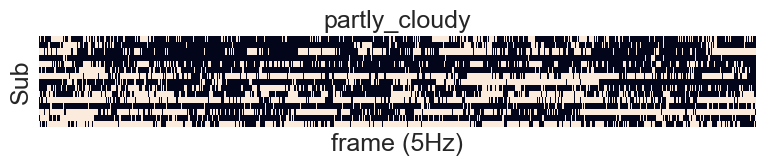

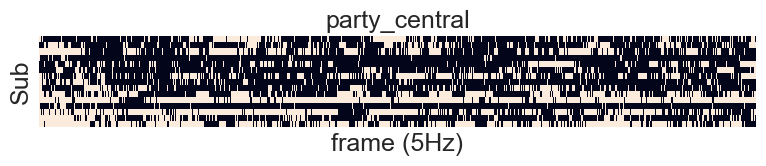

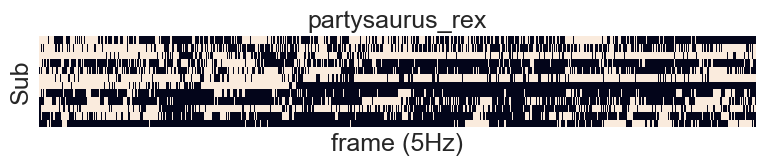

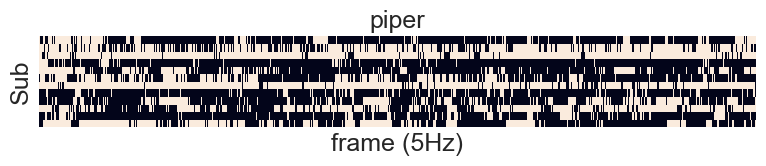

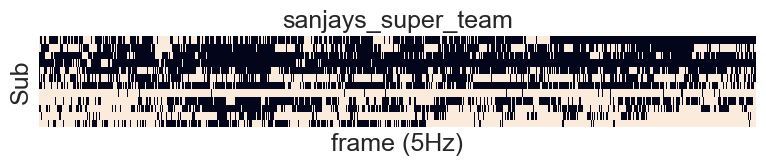

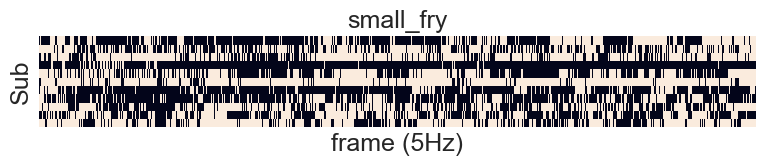

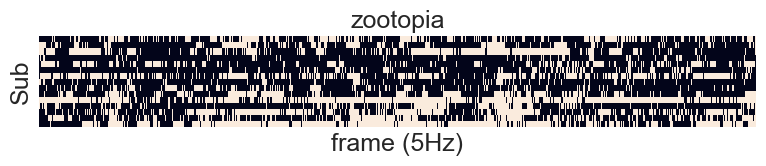

In [57]:
for mov in clipinfo.index:
    plt.figure(figsize=(8,2))
    sns.heatmap(clipmotion[mov].T>0.2, vmax=1, cbar=False)   
    plt.xticks([])
    plt.ylabel('Sub')
    plt.xlabel('frame (5Hz)')
    plt.yticks([])
    plt.title(mov)
    
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_{0}_motion_cens02_timeplot.png'.format(mov)), dpi=200)
    plt.show()
    plt.close()

# examine ratings

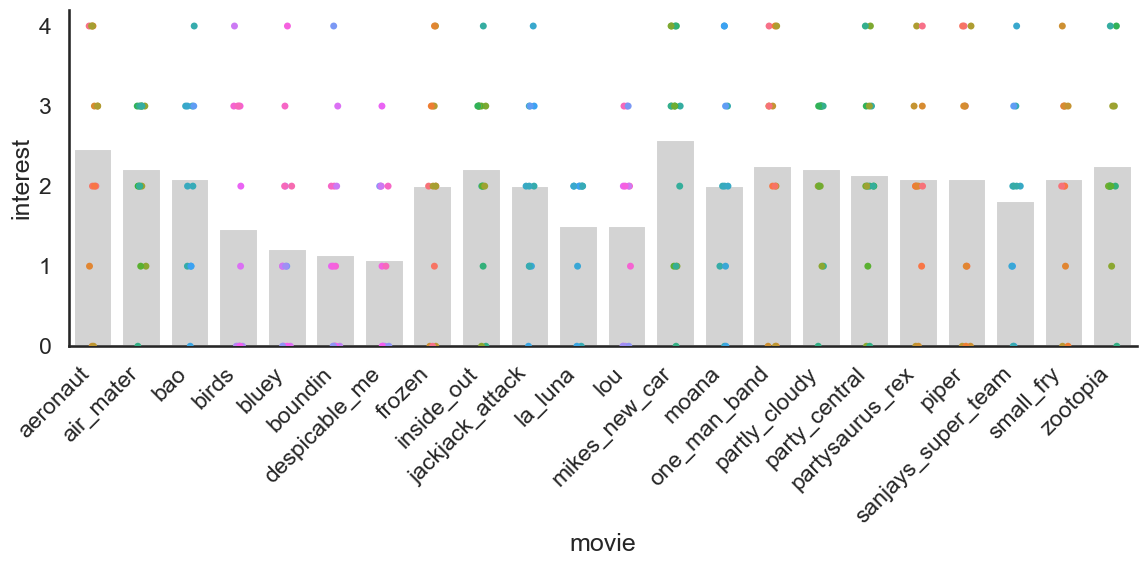

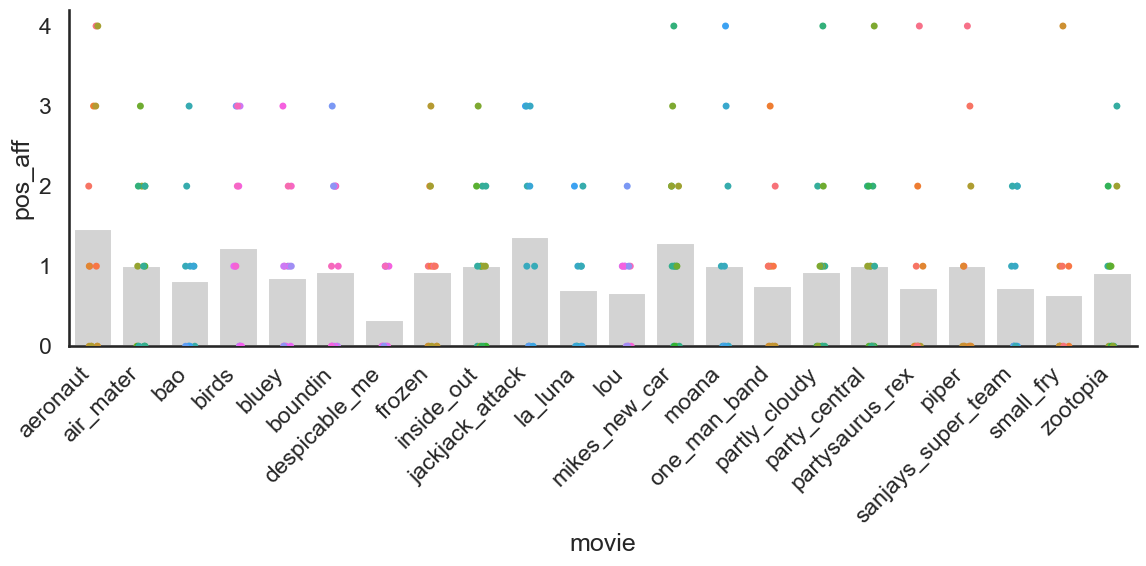

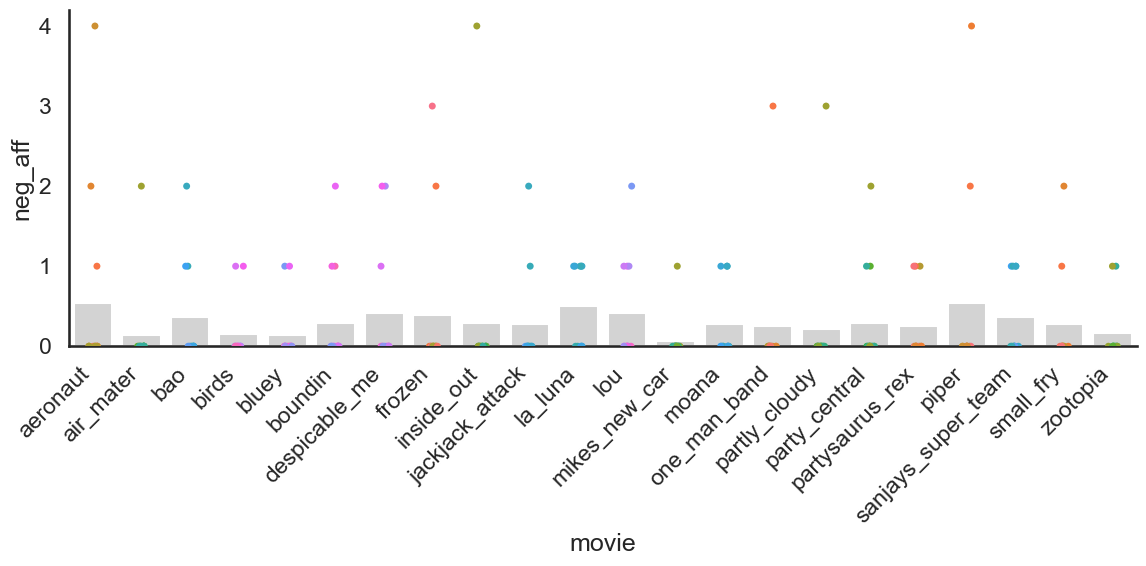

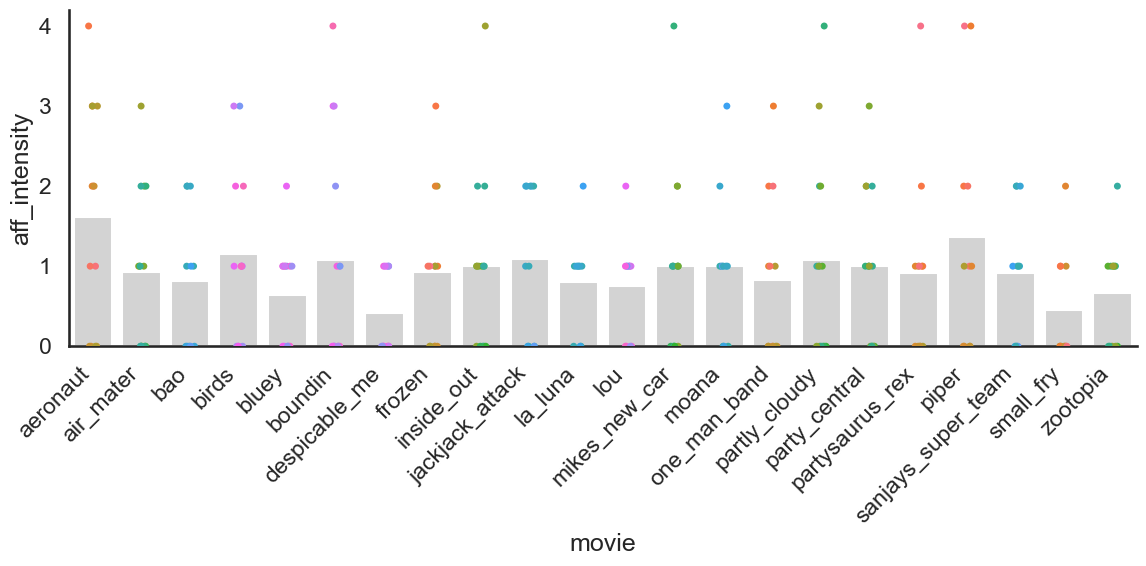

In [58]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:

    plt.figure(figsize=(12,6))
    sns.barplot(y=v,x='movie', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='movie', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_clip_affect_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()

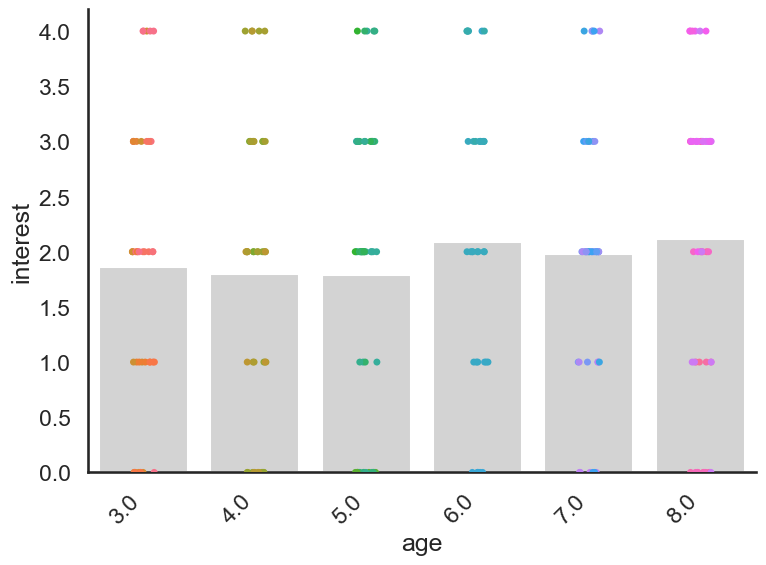

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

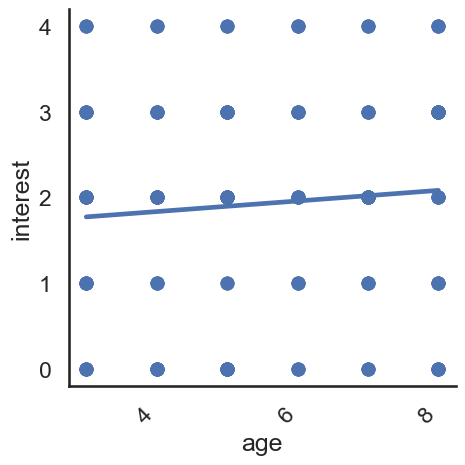

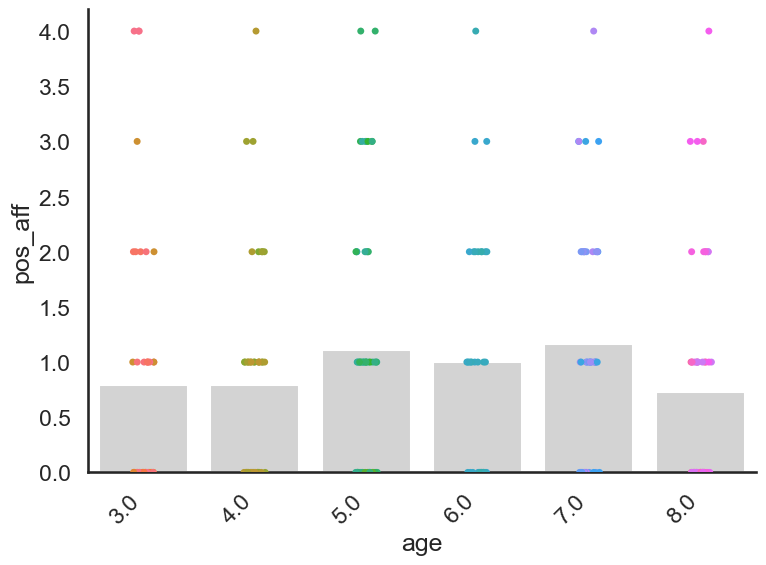

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

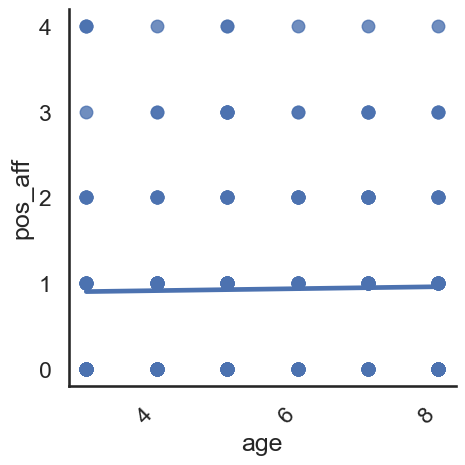

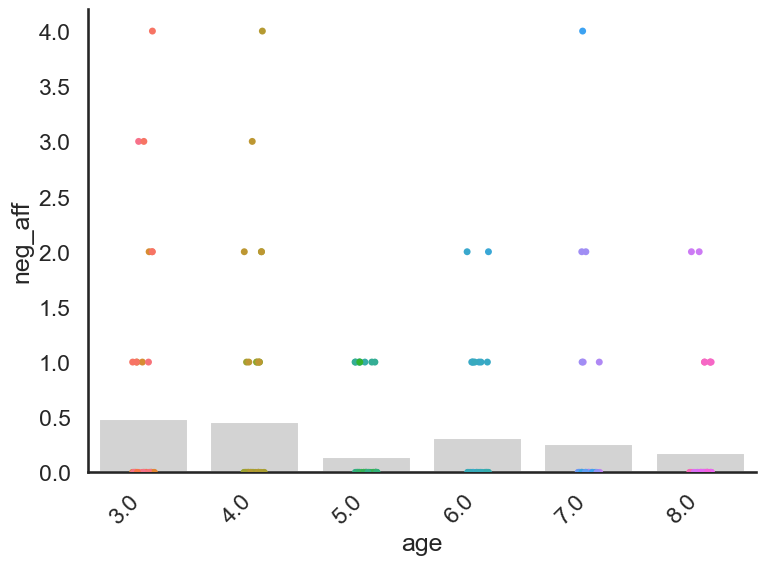

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

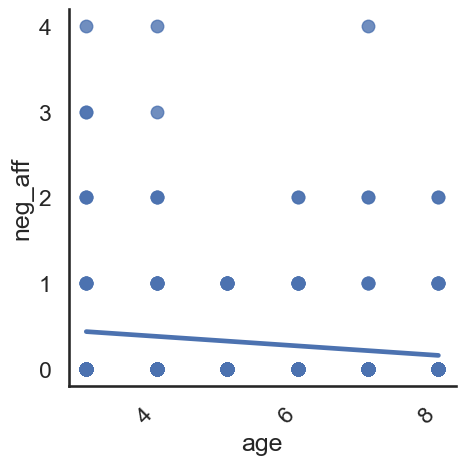

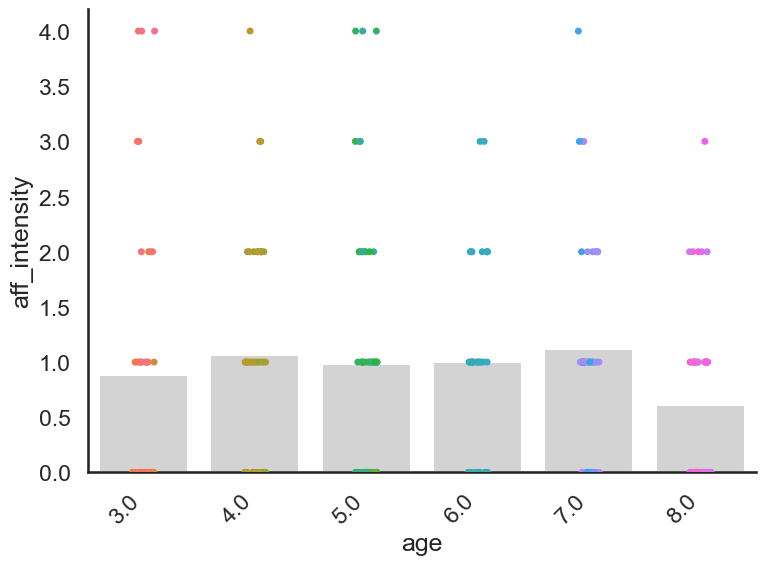

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 800x600 with 0 Axes>

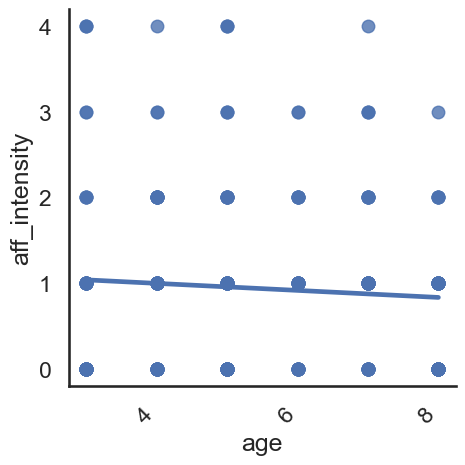

In [59]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:

    plt.figure(figsize=(8,6))
    sns.barplot(y=v,x='age', data=data, color='lightgray',errwidth=0)
    sns.stripplot(y=v,x='age', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_affect_{0}_plot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()
    
    plt.figure(figsize=(8,6))
    sns.lmplot(y=v,x='age', data=data, scatter=True, ci=None)
    #sns.stripplot(y=v,x='age', data=data, hue='sub')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(os.path.join(figs_dir, 'fullsample_age_affect_{0}_lineplot.png'.format(v)), dpi=200)
    plt.show()
    plt.close()


################### interest - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.7591   
Min. group size:  2       Log-Likelihood:     -401.9862
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.917    0.159 12.030 0.000  1.605  2.229
human        -0.006    0.128 -0.048 0.962 -0.258  0.245
sub Var       0.961    0.280                           



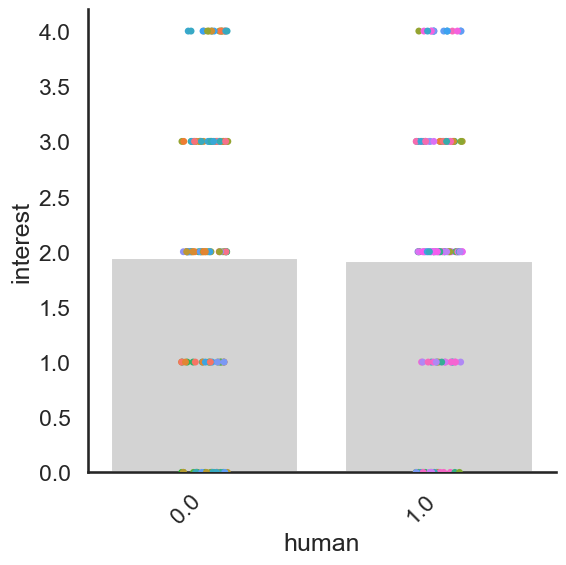


################### interest - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.7570   
Min. group size:  2       Log-Likelihood:     -401.7984
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.968    0.162 12.177 0.000  1.651  2.284
speaking     -0.089    0.114 -0.784 0.433 -0.313  0.134
sub Var       0.962    0.281                           



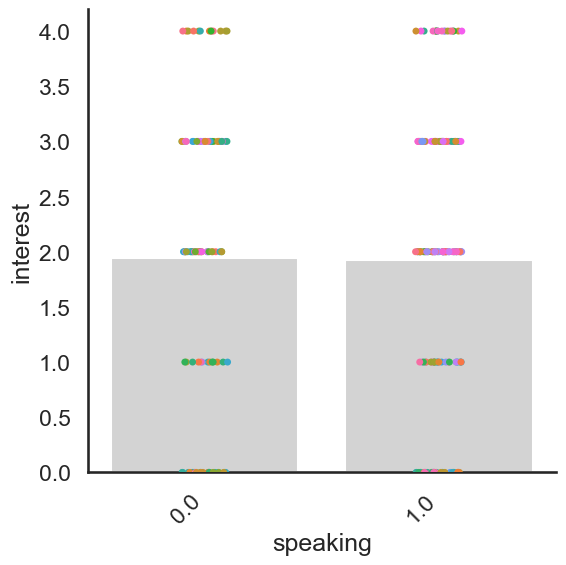


################### interest - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: interest 
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.7563   
Min. group size:  2       Log-Likelihood:     -401.6554
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.833    0.177 10.372 0.000  1.486  2.179
contained     0.105    0.128  0.822 0.411 -0.145  0.355
sub Var       0.965    0.282                           



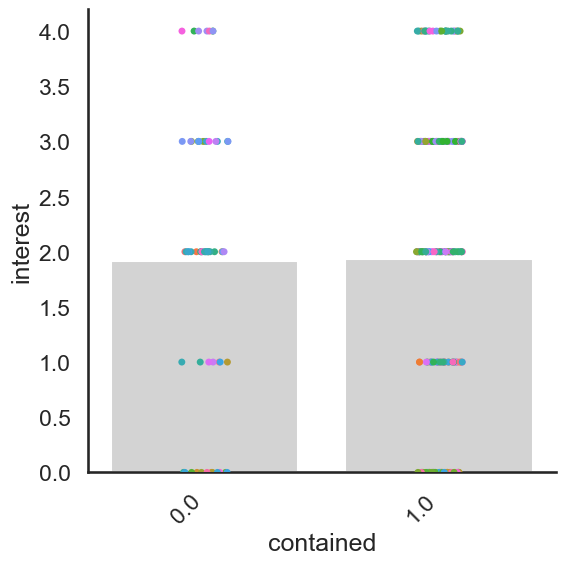


################### pos_aff - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.7870   
Min. group size:  2       Log-Likelihood:     -389.6128
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     1.018    0.123  8.279 0.000  0.777  1.259
human        -0.127    0.126 -1.002 0.316 -0.374  0.121
sub Var       0.429    0.150                           



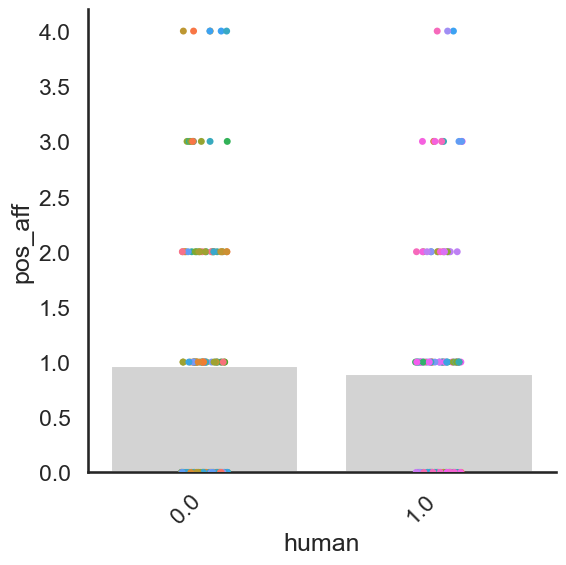


################### pos_aff - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.7924   
Min. group size:  2       Log-Likelihood:     -390.1841
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.969    0.126  7.666 0.000  0.722  1.217
speaking     -0.023    0.116 -0.198 0.843 -0.249  0.204
sub Var       0.422    0.147                           



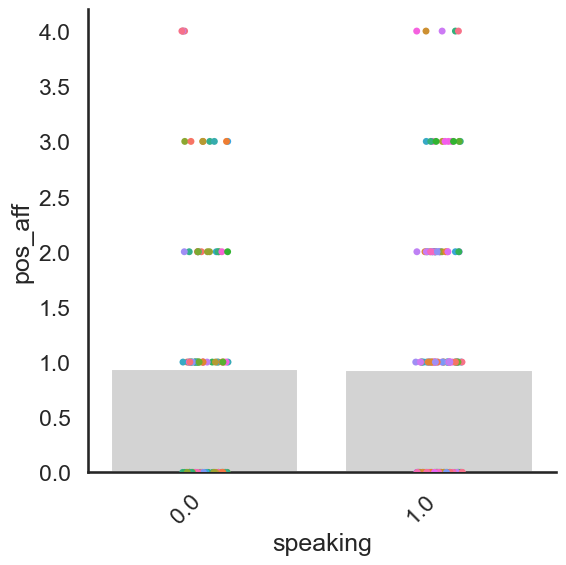


################### pos_aff - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pos_aff  
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.7879   
Min. group size:  2       Log-Likelihood:     -389.5147
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.848     0.146  5.818  0.000   0.563   1.134
contained  0.139     0.130  1.069  0.285  -0.116   0.393
sub Var    0.424     0.148                              



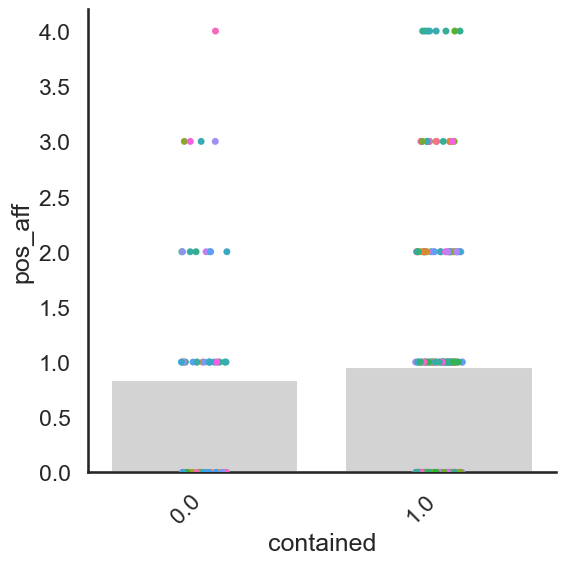


################### neg_aff - human ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.3435   
Min. group size:  2       Log-Likelihood:     -272.8343
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.214     0.075  2.838  0.005   0.066   0.361
human      0.148     0.082  1.801  0.072  -0.013   0.309
sub Var    0.143     0.076                              



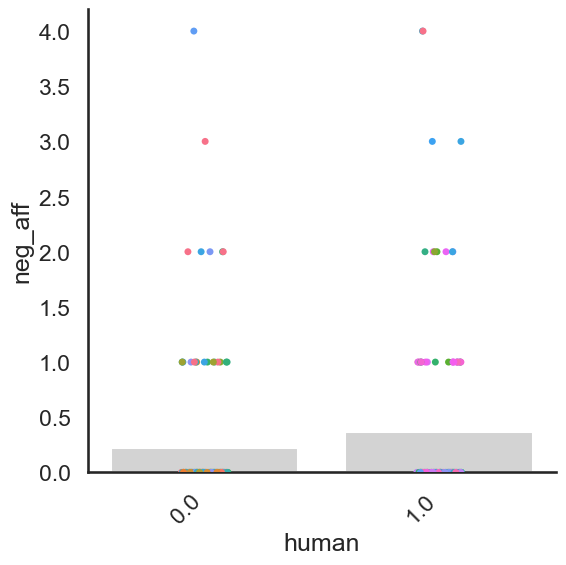


################### neg_aff - speaking ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.3460   
Min. group size:  2       Log-Likelihood:     -273.6866
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.346    0.078  4.404 0.000  0.192  0.499
speaking     -0.099    0.076 -1.297 0.195 -0.248  0.051
sub Var       0.142    0.076                           



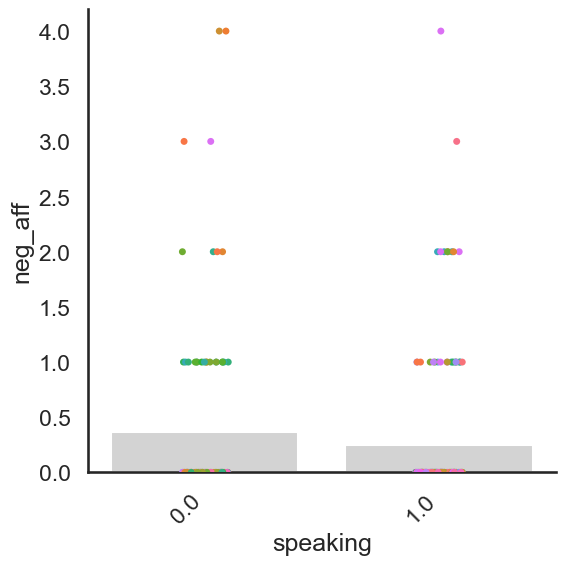


################### neg_aff - contained ###################

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: neg_aff  
No. Observations: 272     Method:             REML     
No. Groups:       52      Scale:              0.3477   
Min. group size:  2       Log-Likelihood:     -274.3094
Max. group size:  6       Converged:          Yes      
Mean group size:  5.2                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.315    0.092  3.410 0.001  0.134  0.496
contained    -0.037    0.086 -0.434 0.664 -0.206  0.131
sub Var       0.144    0.076                           



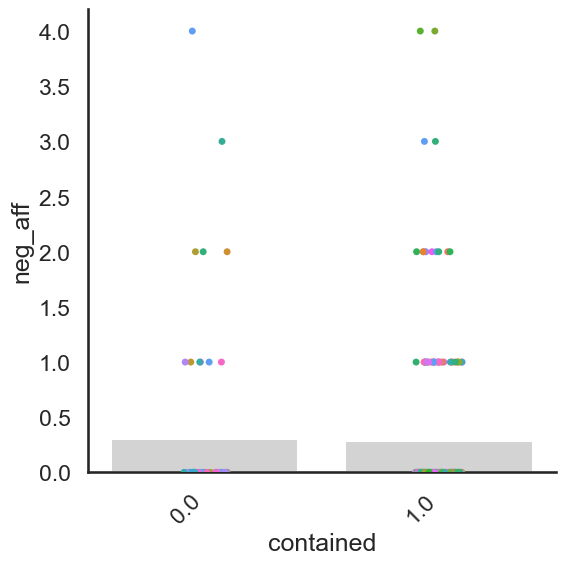


################### aff_intensity - human ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 272     Method:             REML         
No. Groups:       52      Scale:              0.5882       
Min. group size:  2       Log-Likelihood:     -356.3388    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.2                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     0.976     0.117   8.357  0.000   0.747   1.205
human        -0.046     0.111  -0.412  0.680  -0.263   0.171
sub Var       0.438     0.160                               



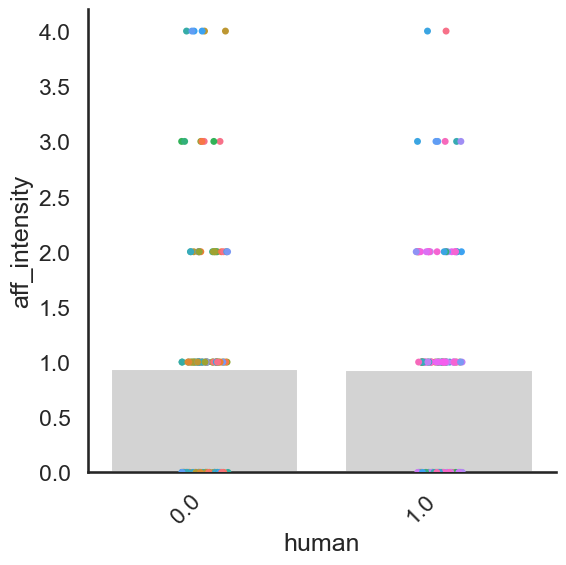


################### aff_intensity - speaking ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 272     Method:             REML         
No. Groups:       52      Scale:              0.5778       
Min. group size:  2       Log-Likelihood:     -354.4713    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.2                                      
------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept     1.075     0.119   9.014  0.000   0.841   1.309
speaking     -0.202     0.099  -2.037  0.042  -0.396  -0.008
sub Var       0.439     0.161                               



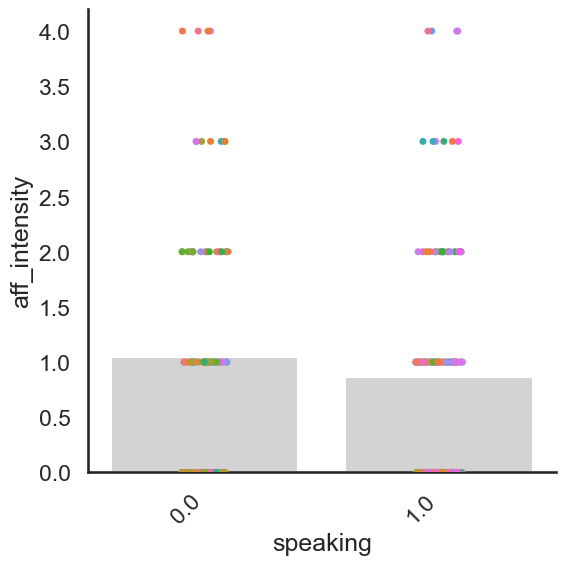


################### aff_intensity - contained ###################

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: aff_intensity
No. Observations: 272     Method:             REML         
No. Groups:       52      Scale:              0.5828       
Min. group size:  2       Log-Likelihood:     -355.2429    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.2                                      
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.821     0.135  6.098  0.000   0.557   1.085
contained      0.171     0.112  1.531  0.126  -0.048   0.390
sub Var        0.437     0.160                              



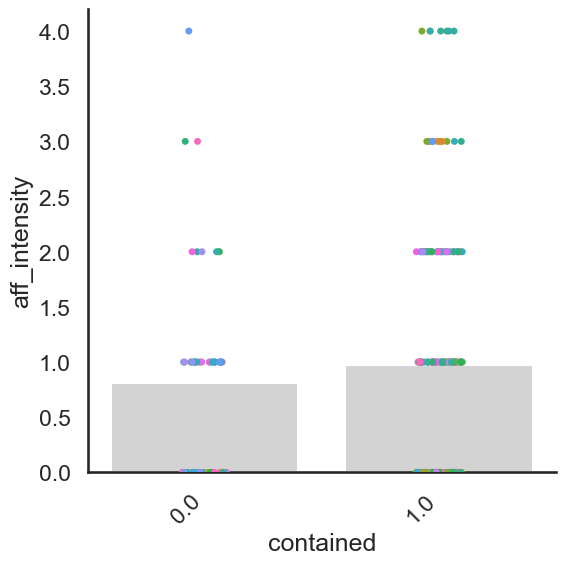

In [60]:
for v in ['interest', 'pos_aff', 'neg_aff','aff_intensity']:
    for f in ['human','speaking','contained']:

        print('')
        print('################### {0} - {1} ###################'.format(v, f))
        print('')

        temp = data.dropna().copy()
        res = smf.mixedlm('{0} ~ {1}'.format(v,f), groups='sub', data=temp).fit()
        print(res.summary())
        
        plt.figure(figsize=(6,6))
        sns.barplot(y=v,x=f, data=data, color='lightgray', errwidth=0)
        sns.stripplot(y=v,x=f, data=data, hue='sub')
        plt.xticks(rotation=45, ha='right')
        sns.despine()
        plt.legend().remove()
        plt.tight_layout()
        plt.savefig(os.path.join(figs_dir, 'fullsample_feature_{0}_affect_{1}_plot.png'.format(f,v)), dpi=200)
        plt.show()
        plt.close()